### Load Packages and Functions

In [6]:
import yt
from helper_functions import ss_properties, extract_simulation_name
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u
from yt.units import kboltz, mp

from yt.fields.field_detector import FieldDetector
from yt.utilities.physical_constants import c

from yt.units import Msun, yr, pc
from scipy.constants import m_p as m_h  # Proton mass in kg

# Define the cosmology with the given parameters
cosmo = FlatLambdaCDM(H0=71 * u.km / u.s / u.Mpc, Om0=0.266, Ob0=0.0449)

# Initial redshift
z_initial = 19.23 # h1 at z=26.31, h2 at z=19.23

# Convert 2.5 Myr to the correct units
delta_t = 0.5 * u.Myr

# Look at the time corresponding to the initial redshift
t_initial = cosmo.lookback_time(z_initial)

# Add the 2.5 Myr to the time
t_new = t_initial - delta_t

# Compute the new redshift after 2.5 Myr using inverse lookback time
z_new = z_at_value(cosmo.lookback_time, t_new)

# Output the result
print(f"New redshift after 2.5 Myr: z = {z_new:.2f}")


New redshift after 2.5 Myr: z = 19.20 redshift


In [4]:
# Calculate Specific Heating Rate

def _bh_specific_heating_rate(field, data):
    field_data = data.ds.arr(np.zeros(data["gas", "density"].shape), "erg/s/g")
    if isinstance(data, FieldDetector):
        return field_data

    # get all black holes in this data object
    cell_pos = data.ds.arr([data["index", ax] for ax in "xyz"]).T
    bh_pos = data.get_field_parameter("bh_centers")
    bh_r = data.get_field_parameter("bh_feedback_radii")
    mdot = data.get_field_parameter("accretion_rate")
    epsilon = data.get_field_parameter("epsilon")
    print(f"bh_pos: {bh_pos}, bh_r: {bh_r}, mdot: {mdot}")

    # loop over each bh and add heating where d < r
    for i in range(bh_r.size):
        my_pos = bh_pos[i]
        my_r2 = bh_r[i]**2
        d2 = ((cell_pos - my_pos)**2).sum(axis=1)
        my_mdot = mdot[i]
        my_filter = d2 <= my_r2
        field_data[my_filter] = epsilon * c**2 * my_mdot / \
          data["gas", "cell_mass"] / my_filter.sum()
        # total_mass_in_region = data["gas", "cell_mass"][my_filter].sum()
        # field_data[my_filter] = epsilon * c**2 * my_mdot / data["gas", "cell_mass"] * (data["gas", "cell_mass"] / total_mass_in_region)

    return field_data

yt.add_field(("gas", "BH_specific_heating_rate"),
             _bh_specific_heating_rate,
             sampling_type="local",
             units="erg/s/g")

def _bh_accretion_cooling_time(field, data):
    # assume here that cooling is positive
    edot = data["gas", "specific_thermal_energy"] / data["gas", "cooling_time"]
    edot_bh = data["gas", "BH_specific_heating_rate"]
    edot_net = edot - edot_bh
    return data["gas", "specific_thermal_energy"] / edot_net

yt.add_field(("gas", "BH_accretion_cooling_time"),
             _bh_accretion_cooling_time,
             sampling_type="local",
             units="s")

def _bh_accretion_heating_to_cooling_ratio(field, data):
    edot = data["gas", "specific_thermal_energy"] / data["gas", "cooling_time"]
    edot_bh = data["gas", "BH_specific_heating_rate"]
    return edot_bh / edot

yt.add_field(("gas", "BH_accretion_heating_to_cooling_ratio"),
             _bh_accretion_heating_to_cooling_ratio,
             sampling_type="local",
             units="")

def bh_prepare_object(data, epsilon=None):
    spos = data["SmartStar", "particle_position"]
    sdx = data.ds.find_field_values_at_points([("index", "dx")], spos)
    try:
        r_cells = ds.parameters['SmartStarBHThermalFeedbackRadiusinCells']
    except KeyError:
        r_cells = 5
    data.set_field_parameter("bh_centers", spos)
    data.set_field_parameter("bh_feedback_radii", r_cells * sdx)
    data.set_field_parameter("epsilon", epsilon)
    mdot_now = data["SmartStar", "AccretionRate"][:, -1]
    data.set_field_parameter("accretion_rate", mdot_now)

## Calculate the ratio of cooling time / sound speed to identify potential overcooling in simulation
This is from Vecchia + Schaye 2012 (Simulating galactic outflows with thermal supernova feedback). 
To identify overcooling, the paper proposes criteria based on the ratio of radiative cooling time (tc) to the sound-crossing time (ts​). When tc/ts > 8-10, feedback can overcome radiative losses, allowing the gas to expand adiabatically and convert thermal to kinetic energy. This was applied to supernova thermal feedback.

Their threshold of tc/ts > 8-10 may be too high for my simulations. Their gas particles at a minimum were 500 msun smoothed over 10 pc. My simulations are sub-pc scale.

The ratio of cooling time to sound-crossing time, \($\frac{t_c}{t_s}$\), indicates the relative importance of radiative cooling versus adiabatic expansion (or compression). The key interpretations are:

1. \( $\frac{t_c}{t_s} \gg 1$ \): Cooling is inefficient compared to the gas dynamics. In this regime, gas can expand and convert thermal energy into kinetic energy before losing much of it to radiation. This is desirable for effective feedback, such as when heating gas via supernovae or black hole feedback. The injected energy drives gas outflows, reduces star formation, and influences the structure of the interstellar medium (ISM).
    
2. \( $\frac{t_c}{t_s} \ll 1$ \): Cooling is very efficient, meaning the gas loses thermal energy rapidly before it can respond dynamically. In this regime, any heating from feedback (e.g., supernovae or black hole jets) is quickly radiated away, leading to poor coupling of feedback energy with the gas. This can result in the "overcooling problem" in simulations, where the gas collapses and forms stars too efficiently, and feedback fails to generate large-scale outflows.
    
3. \($ \frac{t_c}{t_s} \approx 1 $ \): Cooling and adiabatic processes are comparable. The gas may begin to cool before significant expansion occurs, but not so rapidly that feedback is entirely ineffective. This intermediate regime is often where fine-tuning feedback models becomes important in simulations.



In [5]:
def calculate_tc_ts_ratio(dataset, width=(10, "pc"), orientation="x", title=None):
    # Load the dataset
    ds = yt.load(dataset)
    sim = extract_simulation_name(dataset)
    ss_pos, ss_mass, _  = ss_properties(ds)
    
    # Check if the necessary fields are available
    if not all([("gas", "cooling_time"), ("gas", "sound_speed")]):
        print("The dataset does not have the required fields for cooling time or sound speed.")
        return
    
    # Define a new field for the tc/ts ratio
    def _tc_ts_ratio(field, data):
        # Use yt's built-in fields for cooling time and sound speed
        tc = data["gas", "cooling_time"]
        h = data["index", "dx"]  # Characteristic length scale (cell size)
        cs = data["gas", "sound_speed"]
        ts = h / cs
        return tc / ts

    # Add the tc/ts ratio field to the dataset
    ds.add_field(("gas", "tc_ts_ratio"), function=_tc_ts_ratio, 
                 units="", sampling_type="cell", display_name="Cooling Time / Sound Crossing Time")

    # Create a slice plot of the tc/ts ratio
    plot = yt.SlicePlot(ds, orientation, ("gas", "tc_ts_ratio"), center=ss_pos, width=width)
    plot.set_cmap(("gas", "tc_ts_ratio"), "coolwarm")
    plot.set_log(("gas", "tc_ts_ratio"), True)
    plot.set_zlim(("gas", "tc_ts_ratio"), 1e-1, 1e4)
    plot.set_axes_unit("pc")
    plot.annotate_title(f"{title} ({ss_mass:.2e})") if title else None
    plot.show()

    # Create a slice plot of the tc/ts ratio
    plot = yt.SlicePlot(ds, orientation, ("gas", "number_density"), center=ss_pos, width=width)
    plot.set_log(("gas", "number_density"), True)
    plot.set_cmap(("gas", "number_density"), "viridis")
    #plot.set_zlim(("gas", "number_density"), 8, 1e4)
    plot.set_axes_unit("pc")
    plot.show()

### Event 2
60,000 msun BH

yt : [INFO     ] 2024-10-11 17:19:29,224 Parameters: current_time              = 17.497413206594
yt : [INFO     ] 2024-10-11 17:19:29,226 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-11 17:19:29,228 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-11 17:19:29,229 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-11 17:19:29,231 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-11 17:19:29,232 Parameters: current_redshift          = 22.459988284746
yt : [INFO     ] 2024-10-11 17:19:29,234 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-11 17:19:29,235 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-11 17:19:29,236 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-11 17:19:29,237 Parameters: hubble_constant           = 0.71


ds =  DD2783


Parsing Hierarchy : 100%|██████████| 3838/3838 [00:00<00:00, 10030.48it/s]
yt : [INFO     ] 2024-10-11 17:19:29,731 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2024-10-11 17:19:32,490 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 17:19:32,492 ylim = 0.508225 0.508292
yt : [INFO     ] 2024-10-11 17:19:32,495 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 17:19:32,497 ylim = 0.508225 0.508292
yt : [INFO     ] 2024-10-11 17:19:32,502 Making a fixed resolution buffer of (('gas', 'tc_ts_ratio')) 800 by 800



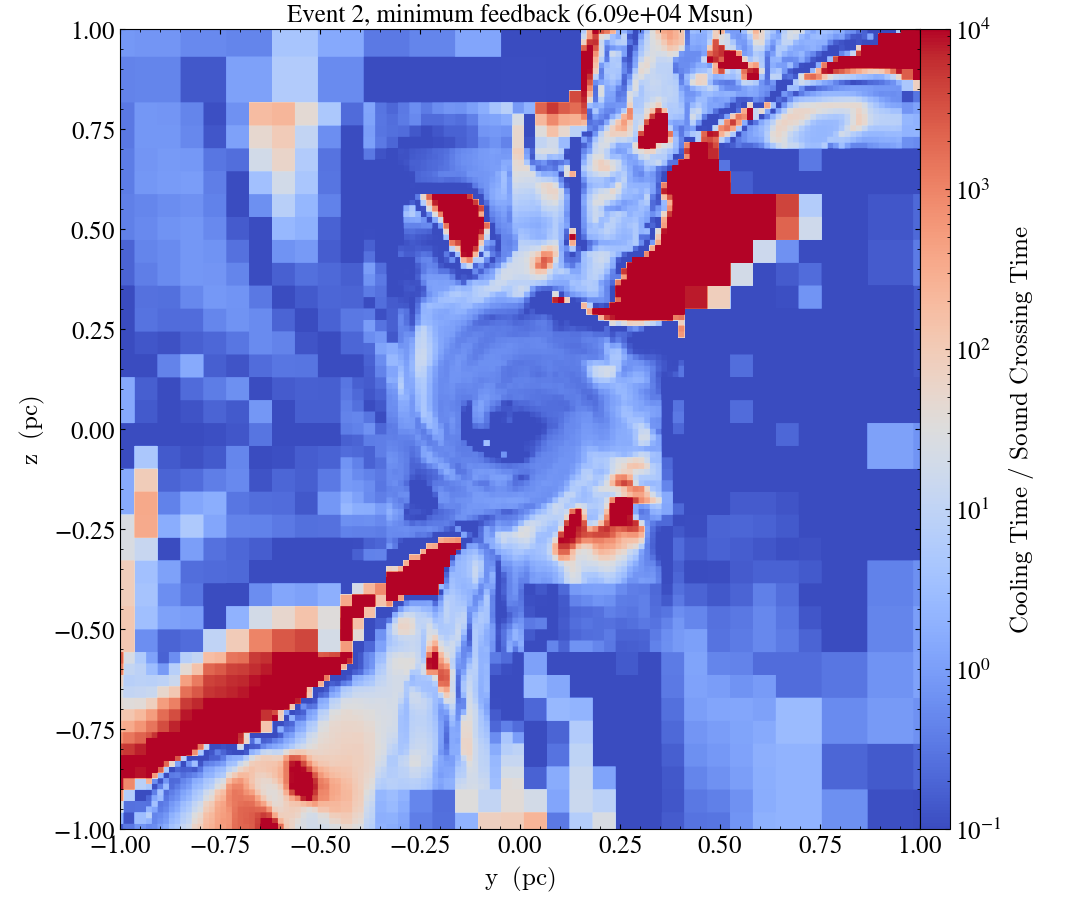

yt : [INFO     ] 2024-10-11 17:19:34,037 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 17:19:34,038 ylim = 0.508225 0.508292
yt : [INFO     ] 2024-10-11 17:19:34,042 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 17:19:34,043 ylim = 0.508225 0.508292
yt : [INFO     ] 2024-10-11 17:19:34,045 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



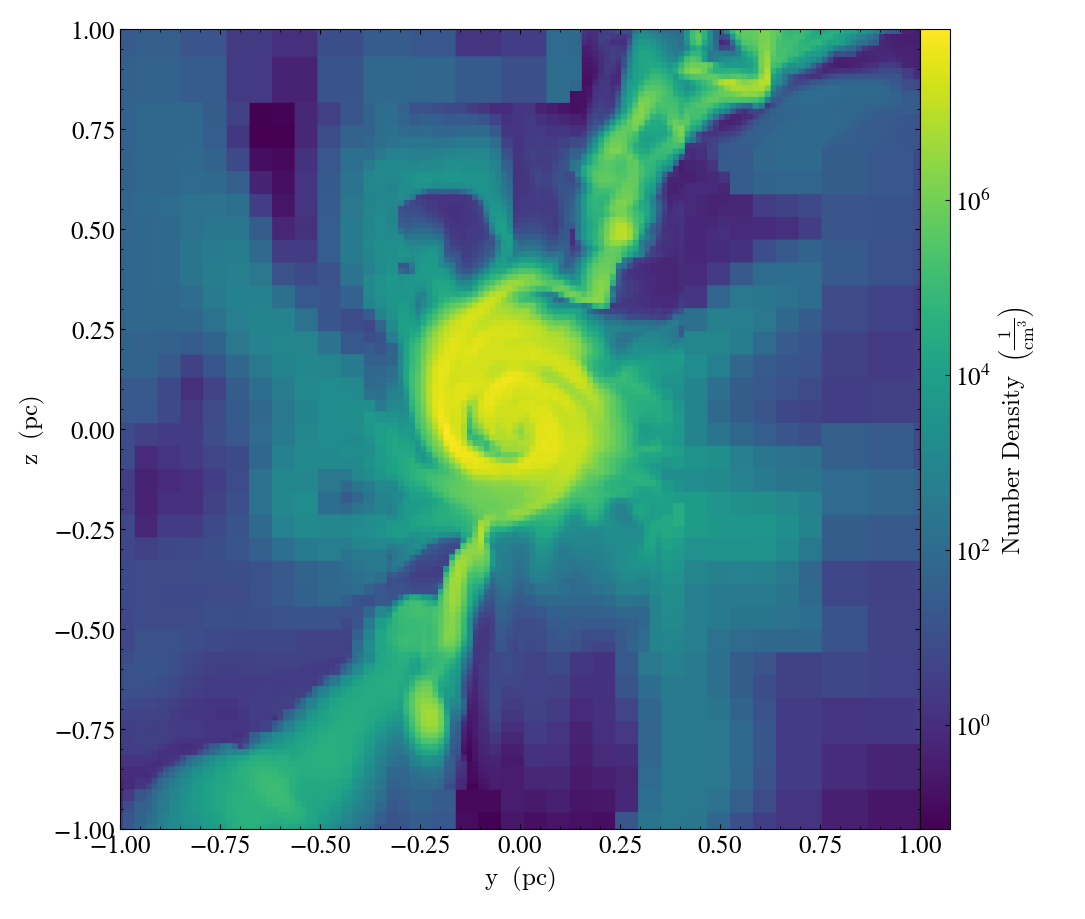

In [3]:
# Event 2, minimum feedback
fp = "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eps-0.001/DD2783/DD2783"
calculate_tc_ts_ratio(fp, width=(2, "pc"), orientation="x", title= "Event 2, minimum feedback")

yt : [INFO     ] 2024-10-11 08:15:19,553 Parameters: current_time              = 17.497046862082
yt : [INFO     ] 2024-10-11 08:15:19,554 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-11 08:15:19,555 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-11 08:15:19,556 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-11 08:15:19,557 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-11 08:15:19,558 Parameters: current_redshift          = 22.460315768987
yt : [INFO     ] 2024-10-11 08:15:19,559 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-11 08:15:19,559 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-11 08:15:19,560 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-11 08:15:19,561 Parameters: hubble_constant           = 0.71


ds =  DD0641


Parsing Hierarchy : 100%|██████████| 4531/4531 [00:00<00:00, 10768.29it/s]
yt : [INFO     ] 2024-10-11 08:15:20,067 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2024-10-11 08:15:22,899 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 08:15:22,900 ylim = 0.508225 0.508291
yt : [INFO     ] 2024-10-11 08:15:22,903 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 08:15:22,904 ylim = 0.508225 0.508291
yt : [INFO     ] 2024-10-11 08:15:22,905 Making a fixed resolution buffer of (('gas', 'tc_ts_ratio')) 800 by 800



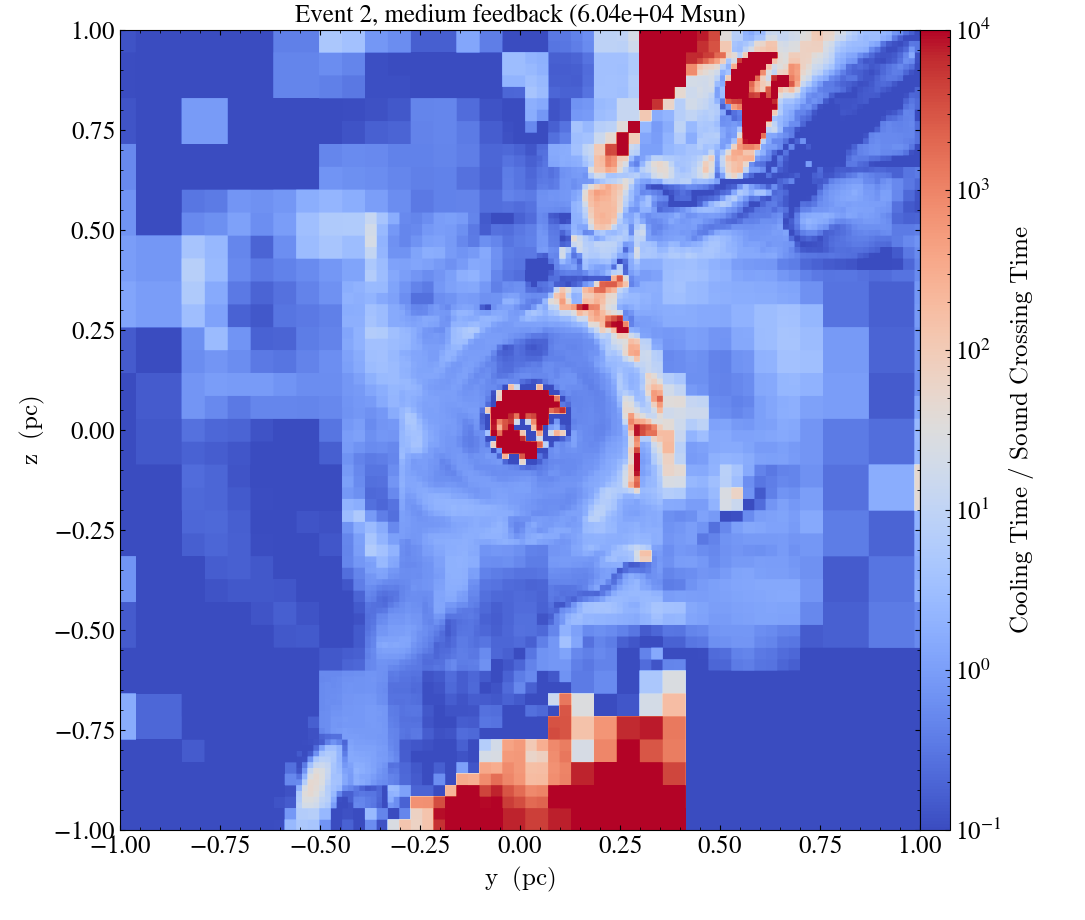

yt : [INFO     ] 2024-10-11 08:15:23,693 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 08:15:23,694 ylim = 0.508225 0.508291
yt : [INFO     ] 2024-10-11 08:15:23,696 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 08:15:23,697 ylim = 0.508225 0.508291
yt : [INFO     ] 2024-10-11 08:15:23,699 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



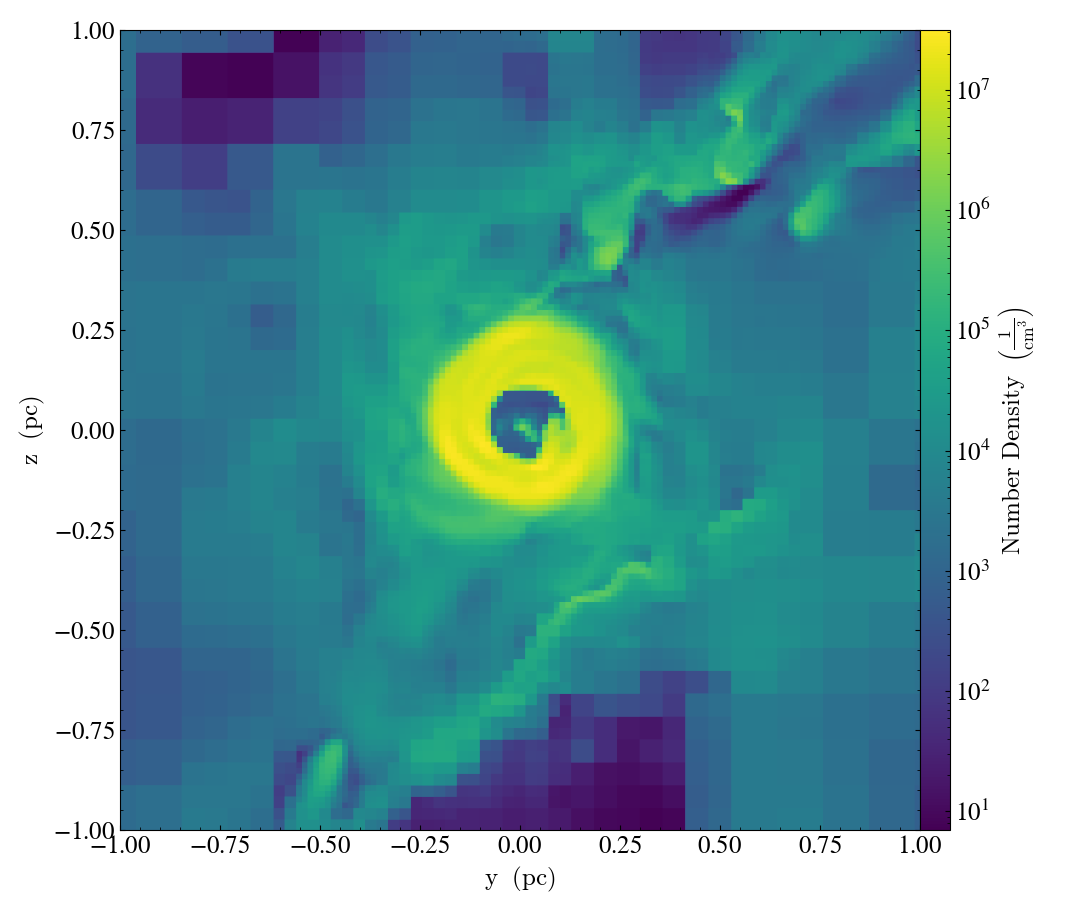

In [58]:
# Event 2, medium feedback
fp = "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.01/DD0641/DD0641"
calculate_tc_ts_ratio(fp, width=(2, "pc"), orientation="x", title= "Event 2, medium feedback")

yt : [INFO     ] 2024-10-11 08:16:03,477 Parameters: current_time              = 17.497448947522
yt : [INFO     ] 2024-10-11 08:16:03,478 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-11 08:16:03,480 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-11 08:16:03,482 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-11 08:16:03,484 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-11 08:16:03,485 Parameters: current_redshift          = 22.459956335676
yt : [INFO     ] 2024-10-11 08:16:03,486 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-11 08:16:03,488 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-11 08:16:03,489 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-11 08:16:03,490 Parameters: hubble_constant           = 0.71


ds =  DD0695


Parsing Hierarchy : 100%|██████████| 5465/5465 [00:01<00:00, 5275.30it/s]
yt : [INFO     ] 2024-10-11 08:16:04,690 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2024-10-11 08:16:39,121 xlim = 0.492843 0.492909
yt : [INFO     ] 2024-10-11 08:16:39,123 ylim = 0.508224 0.508290
yt : [INFO     ] 2024-10-11 08:16:39,131 xlim = 0.492843 0.492909
yt : [INFO     ] 2024-10-11 08:16:39,133 ylim = 0.508224 0.508290
yt : [INFO     ] 2024-10-11 08:16:39,138 Making a fixed resolution buffer of (('gas', 'tc_ts_ratio')) 800 by 800



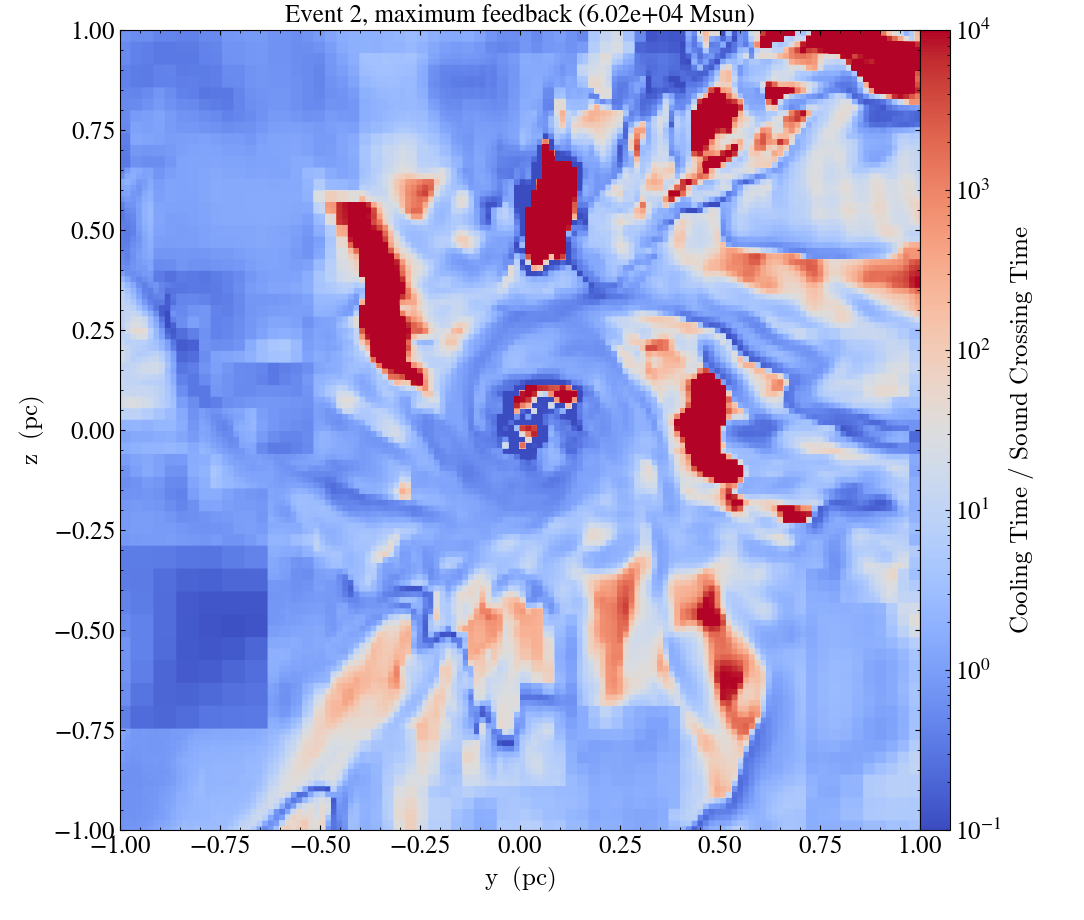

yt : [INFO     ] 2024-10-11 08:16:52,772 xlim = 0.492843 0.492909
yt : [INFO     ] 2024-10-11 08:16:52,773 ylim = 0.508224 0.508290
yt : [INFO     ] 2024-10-11 08:16:52,779 xlim = 0.492843 0.492909
yt : [INFO     ] 2024-10-11 08:16:52,781 ylim = 0.508224 0.508290
yt : [INFO     ] 2024-10-11 08:16:52,784 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



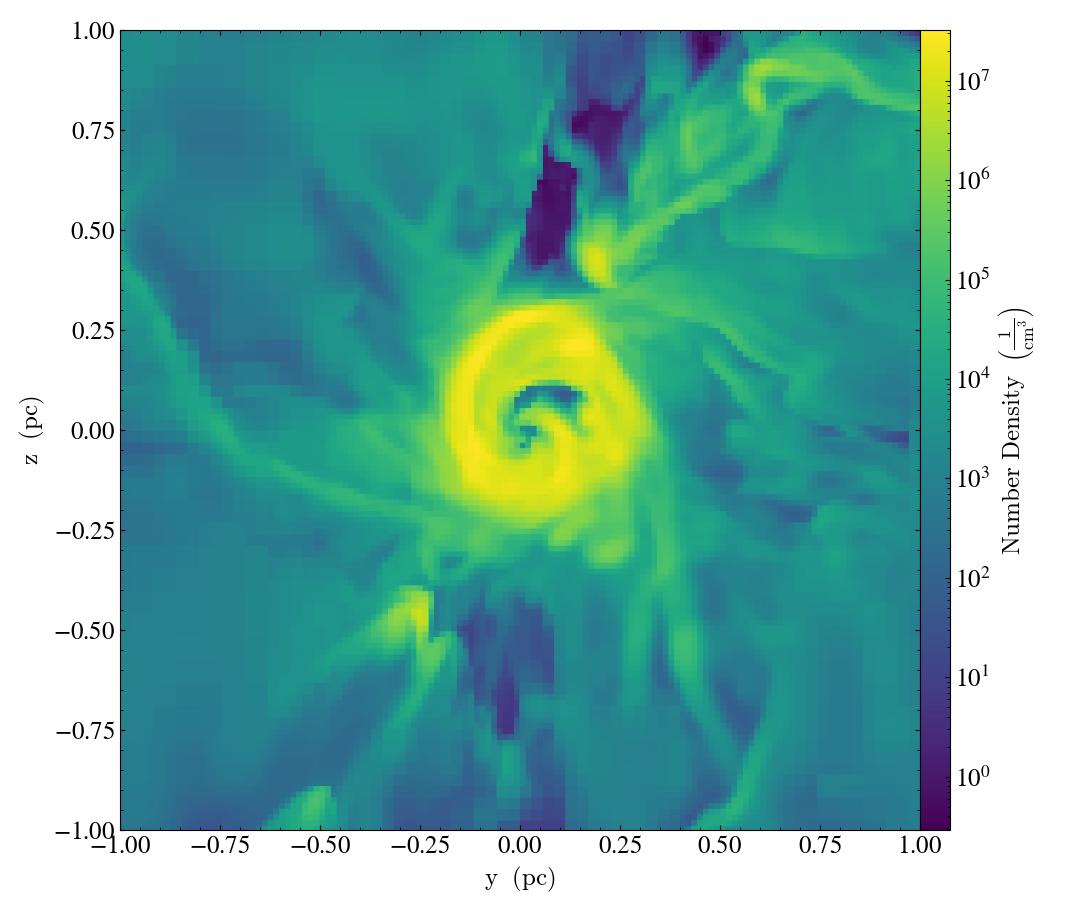

In [59]:
# Event 2, maximum feedback
fp = "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.1/DD0695/DD0695"
calculate_tc_ts_ratio(fp, width=(2, "pc"), orientation="x", title= "Event 2, maximum feedback")

### Event 1

In [27]:
# Event 1: initial state at 2.50 Myr, take fb values at 2.70 Myr
# simulations_1 = [
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04/DD0153/DD0153", "name": "Initial State"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352", "name": "Min Feedback: eps-0.001"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/DD0352/DD0352", "name": "Max Feedback 1: eta-0.1-fbr-5dx"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/fb-r-7dx/DD0352/DD0352", "name": "Max Feedback 2: eta-0.1-fbr-7dx"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/fb-r-10dx/DD0352/DD0352", "name": "Max Feedback 3: eta-0.1-fbr-10dx"},
# ]

# for sim in simulations_1:
#     calculate_tc_ts_ratio(sim["path"], width=(1, "pc"), orientation="x", title = sim["name"])
#     print(sim["name"])

### Event 3

In [28]:

# # Event 3: initial state at 6.5 Myr, take fb values at 6.7 Myr
# simulations_3 = [
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.001/DD0263/DD0263", "name": "Initial State"},
#     #{"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.001/DD1314/DD1314", "name": "Min Feedback"}, # bad data, rerunning
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.01/DD0511/DD0511", "name": "Mid Feedback: eps-0.01"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01/DD0900/DD0900", "name": "Max Feedback 1: eta-0.1-fbr-5dx"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01/2B.resim.th.b01-fb-r-7dx/DD0600/DD0600", "name": "Max Feedback 2: eta-0.1-fbr-7dx"},
# ]

# for sim in simulations_3:
#     print(sim["name"])
#     calculate_tc_ts_ratio(sim["path"], width=(1, "pc"), orientation="x", title = sim["name"])

# Heating time
Calculate the time it takes to heat the gas from accretion processes where heating_time = thermal_energy/heating_rate, where
- thermal_energy = (3/2) * (density / mean_molecular_weight) * k_B * T * volume
- heating_rate = epsilon * bh_accretion_rate * c**2  # in erg/s

net_thermal_change_time = heating_time - cooling_time.

-> Negative net means that cooling_time >> heating_time -> heating is the dominant process

In [7]:
# Load the dataset
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/DD0352/DD0352")
cell_width = ds.index.get_smallest_dx().to('cm')  # Gets the smallest cell width in the dataset
epsilon = 0.1 * 0.05 # Define epsilon (feedback efficiency)
radius = 5 * cell_width  # Radius of the sphere

# Define the position of the black hole (in code units)
ss_pos, ss_mass, ss_age = ss_properties(ds)
print(f"Black hole age: {ss_age[0]/1e6:.2f} Myr")

# Create a sphere centered at the black hole position with the defined radius
sphere = ds.sphere(ss_pos, radius)

# Calculate the accretion rate
ad = ds.all_data()
bh_accretion_rate = ad[("SmartStar", "AccretionRate")][0].in_units("g/s")
bh_accretion_rate.to("Msun/yr")

# Calculate the total thermal energy in the sphere
# Thermal energy = (3/2) * (density / mean_molecular_weight) * k_B * T * volume

mean_molecular_weight = 0.6  # Assume a mean molecular weight for fully ionized gas
sphere_volume = (4/3) * np.pi * radius**3
thermal_energy = (1.5 * sphere["gas", "density"] / (mean_molecular_weight * mp) *
                  kboltz * sphere["gas", "temperature"] * cell_width**3).sum().in_units("erg")

# Calculate the energy injection rate (feedback rate)
c = 3.0e10 * yt.units.cm/yt.units.s  # Speed of light in cm/s
heating_rate = epsilon * bh_accretion_rate * c**2  # in erg/s

# Calculate the heating time - cooling time
heating_time = (thermal_energy / heating_rate).in_units("s")

# Output the result
print(f"The heating time for the sphere is {heating_time}.")
print(f"The average heating time accross the whole sphere is {(thermal_energy/np.mean(heating_rate)).in_units('yr'):.5f}")

yt : [INFO     ] 2024-10-21 09:43:46,357 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:43:46,359 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:43:46,361 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:43:46,362 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:43:46,364 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:43:46,365 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:43:46,366 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:43:46,367 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:43:46,368 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:43:46,369 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2794/2794 [00:00<00:00, 7834.29it/s] 
yt : [INFO     ] 2024-10-2

ds =  DD0352
Black hole age: 2.70 Myr
The heating time for the sphere is [1736.02296975 1017.00008829 1302.1611636  ... 1817.33130618 2003.69483471
 2367.43953505] s.
The average heating time accross the whole sphere is 0.00007 yr


/home/sgordon/micromamba/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: divide by zero encountered in divide
  out_arr = func(


In [8]:
net_thermal_change_time = (thermal_energy / np.mean(heating_rate)).in_units("Myr") - sphere["gas", "cooling_time"].mean().in_units("Myr")
net_thermal_change_time

unyt_quantity(-0.64283029, 'Myr')


##### Average heating time across the accretion sphere:
Event 1
- 0.00007 yr for 1B.resim.th.b04-eta-0.1/DD0352/DD0352 at 2.70 Myr
- 0.00010 yr for 1B.resim.th.b04-eta-0.1/fb-r-7dx/DD0352/DD0352 at 2.70 Myr (r = 7dx)
- 0.00803 yr for 1B.resim.th.b04-eta-0.1/fb-r-10dx/DD0352/DD0352 at 2.70 Myr (r = 10dx)
- 0.01773 yr 1B.resim.th.b04-eta-0.01-2/DD0307/DD0307 at 2.72 Myr (epsilon = 0.01 * 0.05)
- 0.77945 yr for 1B.resim.th.b04-eps-0.001/DD0352/DD0352 at 2.70 Myr (epsilon = 0.001 * 0.01)


Net thermal change time 
- -0.09182458, 'Myr' for 1B.resim.th.b04-eps-0.001/DD0352/DD0352 at 2.70 Myr 
- -0.64283029, 'Myr' for 1B.resim.th.b04-eta-0.1/DD0352/DD0352 at 2.70 Myr

# Mass inflow through 2D spherical shell

In [10]:
def mass_inflow_rate(ds, center, radius, thickness):
    """
    Calculate the mass inflow rate through a 2D spherical shell at a given radius.
    
    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shell (typically the position of a black hole or galaxy center).
    radius : float
        The radius of the spherical shell (in code units or specify the unit).
    thickness : float
        The thickness of the shell to approximate the 2D surface.
    
    Returns:
    inflow_rate : float
        The mass inflow rate (in units of mass per time).
    """

    # Create a spherical shell with a small thickness
    shell = ds.sphere(center, radius + thickness) - ds.sphere(center, radius)

    # Get the gas density and radial velocity fields
    density = shell[("gas", "density")]  # in units of g/cm^3 or equivalent
    radial_velocity = shell[("gas", "radial_velocity")].in_units("cm/s")  # positive outward, negative inward
    
    # Select only inward flowing gas (radial_velocity < 0 for inflow)
    inflow_mask = radial_velocity < 0
    inflowing_density = density[inflow_mask]
    inflowing_radial_velocity = radial_velocity[inflow_mask]
    
    # Calculate mass flux: density * velocity * shell volume (cell area)
    cell_areas = shell["cell_area"][inflow_mask]  # Area of each cell in cm^2
    
    # Mass inflow rate is the sum of inflowing mass flux through the shell
    mass_flux = inflowing_density * inflowing_radial_velocity * cell_areas  # in g/s
    
    # Sum the mass flux to get the total inflow rate
    inflow_rate = np.sum(mass_flux)
    
    return inflow_rate


In [11]:
# inflow_rate = mass_inflow_rate(ds, center, radius, thickness)
# print(f"Mass inflow rate: {inflow_rate:.3e} g/s")
# m_h = 1.6735575e-24 * yt.units.g  # Mass of a hydrogen atom
# m_h

In [12]:
# Calculate the mass inflow rate at through a sphere of certain radius
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352")
center = ss_pos  # Center of the sphere, change to match your center
radius = .5*yt.units.pc # Radius of the shell in code units
thickness = ds.index.get_smallest_dx().in_units("pc")  # Small thickness for the spherical shell

# Create a spherical shell with a small thickness
shell = ds.sphere(center, radius + thickness) - ds.sphere(center, radius)

# Get the gas density and radial velocity fields
density = shell[("gas", "density")]  # in units of g/cm^3 or equivalent
radial_velocity = shell[("gas", "radial_velocity")].in_units("cm/s")  # positive outward, negative inward

# Select only inward flowing gas (radial_velocity < 0 for inflow)
inflow_mask = radial_velocity < 0
inflowing_density = density[inflow_mask]
inflowing_radial_velocity = radial_velocity[inflow_mask]

print(f"Sphere radius = {radius:.2f}, Sphere thickness = {thickness:.2e}, cell width = {ds.index.get_smallest_dx().in_units('pc'):.2e}")
print(f"Inflowing Mean Density = {np.mean(inflowing_density/m_h):.2e}, Inflowing Mean radial velocity = {np.mean(inflowing_radial_velocity.to('km/s')):.2e}")

# Get cell volumes and calculate approximate cross-sectional area for the spherical shell
cell_volumes = shell["index", "cell_volume"].in_units("cm**3")  # Volume of each cell in cm^3
cell_radii = shell["index", "dx"].in_units("cm")[inflow_mask]  # Radial distance of each cell
cell_areas = (cell_volumes[inflow_mask] / cell_radii)

# Mass inflow rate is the sum of inflowing mass flux through the shell
mass_flux = inflowing_density * inflowing_radial_velocity * cell_areas # in g/s

# Sum the mass flux to get the total inflow rate
inflow_rate = np.sum(mass_flux)
inflow_rate.to("Msun/yr")


yt : [INFO     ] 2024-10-21 09:47:25,763 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:47:25,765 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:47:25,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:47:25,768 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:47:25,770 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:47:25,771 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:47:25,773 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:47:25,774 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:47:25,776 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:47:25,777 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2750/2750 [00:00<00:00, 14321.22it/s]
yt : [INFO     ] 2024-10-2

Sphere radius = 0.50 pc, Sphere thickness = 3.12e-03 pc, cell width = 3.12e-03 pc
Inflowing Mean Density = 6.17e+08 g/cm**3, Inflowing Mean radial velocity = -5.48e+01 km/s


unyt_quantity(-0.00181587, 'Msun/yr')

yt : [INFO     ] 2024-10-21 09:48:02,427 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:48:02,429 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:48:02,430 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:48:02,432 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:48:02,433 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:48:02,435 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:48:02,436 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:48:02,438 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:48:02,439 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:48:02,440 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2750/2750 [00:00<00:00, 16458.46it/s]
yt : [INFO     ] 2024-10-2

Radius = 0.01 pc, Mass inflow rate = -2.85e-03 Msun/yr
Radius = 0.01 pc, Mass inflow rate = -2.48e-02 Msun/yr
Radius = 0.02 pc, Mass inflow rate = -5.19e-02 Msun/yr
Radius = 0.03 pc, Mass inflow rate = -5.75e-02 Msun/yr
Radius = 0.04 pc, Mass inflow rate = -6.57e-02 Msun/yr
Radius = 0.05 pc, Mass inflow rate = -3.31e-02 Msun/yr
Radius = 0.06 pc, Mass inflow rate = -2.27e-02 Msun/yr
Radius = 0.07 pc, Mass inflow rate = -1.45e-02 Msun/yr
Radius = 0.08 pc, Mass inflow rate = -9.67e-03 Msun/yr
Radius = 0.09 pc, Mass inflow rate = -6.42e-03 Msun/yr
Radius = 0.10 pc, Mass inflow rate = -6.10e-03 Msun/yr
Radius = 0.11 pc, Mass inflow rate = -6.15e-03 Msun/yr
Radius = 0.12 pc, Mass inflow rate = -6.18e-03 Msun/yr
Radius = 0.13 pc, Mass inflow rate = -7.06e-03 Msun/yr
Radius = 0.14 pc, Mass inflow rate = -1.06e-02 Msun/yr
Radius = 0.15 pc, Mass inflow rate = -1.23e-02 Msun/yr
Radius = 0.16 pc, Mass inflow rate = -1.62e-02 Msun/yr
Radius = 0.17 pc, Mass inflow rate = -1.17e-02 Msun/yr
Radius = 0

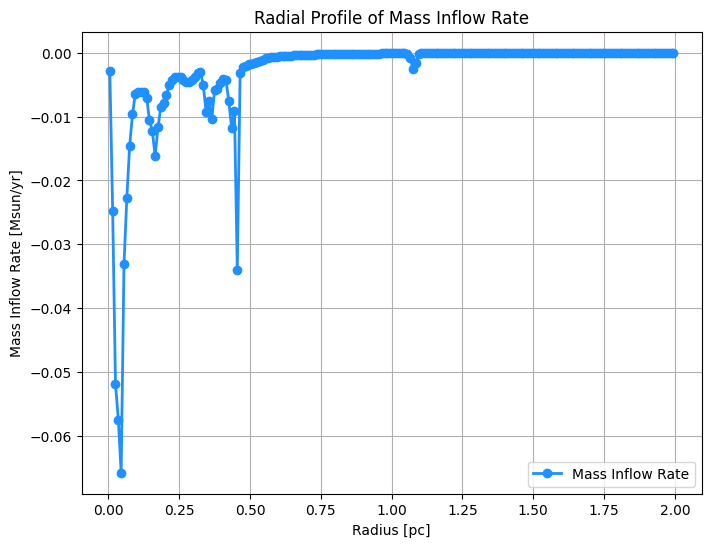

In [13]:

def calculate_mass_inflow_rate(ds, center, radius, thickness):
    """
    Calculate the mass inflow rate through a spherical shell at a given radius.

    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shell (e.g., black hole position).
    radius : float
        The radius of the spherical shell (in pc).
    thickness : float
        The thickness of the shell to approximate the 2D surface (in pc).

    Returns:
    inflow_rate : yt.Quantity
        The mass inflow rate in solar masses per year (Msun/yr).
    """
    
    # Create a spherical shell with a small thickness
    shell = ds.sphere(center, radius + thickness) - ds.sphere(center, radius)

    # Get the gas density and radial velocity fields
    density = shell[("gas", "density")]  # in units of g/cm^3
    radial_velocity = shell[("gas", "radial_velocity")].in_units("cm/s")  # positive outward, negative inward

    # Select only inward flowing gas (radial_velocity < 0 for inflow)
    inflow_mask = radial_velocity < 0
    inflowing_density = density[inflow_mask]
    inflowing_radial_velocity = radial_velocity[inflow_mask]

    # Get cell volumes and calculate approximate cross-sectional area for the spherical shell
    cell_volumes = shell["index", "cell_volume"].in_units("cm**3")  # Volume of each cell in cm^3
    cell_radii = shell["index", "dx"].in_units("cm")[inflow_mask]  # Cell widths (dx) for area approximation
    cell_areas = (cell_volumes[inflow_mask] / cell_radii)

    # Mass inflow rate is the sum of inflowing mass flux through the shell
    mass_flux = inflowing_density * inflowing_radial_velocity * cell_areas  # in g/s

    # Sum the mass flux to get the total inflow rate
    inflow_rate = np.sum(mass_flux).to("Msun/yr")

    return inflow_rate

def plot_radial_inflow_profile(ds, center, min_radius=0, max_radius=2, step=0.02):
    """
    Plot the radial profile of mass inflow rate from 0 to 2 pc in steps of 0.02 pc.

    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shells (e.g., black hole position).
    min_radius : float
        The minimum radius to start calculating the inflow rate (in pc).
    max_radius : float
        The maximum radius to stop calculating the inflow rate (in pc).
    step : float
        The step size for the radial profile (in pc).
    """
    
    # Initialize arrays for radius and inflow rates
    radii = np.arange(min_radius, max_radius, step)*yt.units.pc
    inflow_rates = []

    # Get the smallest cell width to use as thickness
    thickness = ds.index.get_smallest_dx().in_units("pc")

    for r in radii:
        inflow_rate = calculate_mass_inflow_rate(ds, center, r, thickness)
        inflow_rates.append(inflow_rate)

        # Print out some useful information at each radius
        print(f"Radius = {r:.2f}, Mass inflow rate = {inflow_rate:.2e}")

    # Plotting the radial profile of mass inflow rate
    plt.figure(figsize=(8, 6))
    plt.plot(radii, inflow_rates, label="Mass Inflow Rate", color='dodgerblue', lw=2, marker='o')
    plt.xlabel("Radius [pc]")
    plt.ylabel("Mass Inflow Rate [Msun/yr]")
    plt.title("Radial Profile of Mass Inflow Rate")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352")
center = ss_pos  # Set this to your black hole position or desired center

# Plot the radial profile of mass inflow rate
plot_radial_inflow_profile(ds, center, min_radius=0.005*yt.units.pc, max_radius=2*yt.units.pc, step=0.01*yt.units.pc)


# Bondi Rate though 2D spherical shell

yt : [INFO     ] 2024-10-21 09:49:10,259 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:49:10,261 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:49:10,262 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:49:10,264 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:49:10,265 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:49:10,266 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:49:10,267 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:49:10,268 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:49:10,269 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:49:10,270 Parameters: hubble_constant           = 0.71
Parsing Hierarchy :   0%|          | 0/2750 [00:00<?, ?it/s]

Parsing Hierarchy : 100%|██████████| 2750/2750 [00:00<00:00, 18418.07it/s]
yt : [INFO     ] 2024-10-21 09:49:10,489 Gathering a field list (this may take a moment.)


Radius = 0.02 pc, Bondi rate = 7.03e+01 Msun/yr
Radius = 0.07 pc, Bondi rate = 2.07e+02 Msun/yr
Radius = 0.12 pc, Bondi rate = 2.96e+02 Msun/yr
Radius = 0.17 pc, Bondi rate = 6.62e+03 Msun/yr
Radius = 0.22 pc, Bondi rate = 1.52e+03 Msun/yr
Radius = 0.27 pc, Bondi rate = 4.00e+03 Msun/yr
Radius = 0.32 pc, Bondi rate = 3.85e+03 Msun/yr
Radius = 0.37 pc, Bondi rate = 4.66e+03 Msun/yr
Radius = 0.42 pc, Bondi rate = 1.62e+04 Msun/yr
Radius = 0.47 pc, Bondi rate = 8.11e+02 Msun/yr
Radius = 0.52 pc, Bondi rate = 8.86e+02 Msun/yr
Radius = 0.57 pc, Bondi rate = 7.51e+02 Msun/yr
Radius = 0.62 pc, Bondi rate = 7.83e+02 Msun/yr
Radius = 0.67 pc, Bondi rate = 4.22e+02 Msun/yr
Radius = 0.72 pc, Bondi rate = 1.62e+02 Msun/yr
Radius = 0.77 pc, Bondi rate = 5.43e+01 Msun/yr
Radius = 0.82 pc, Bondi rate = 3.13e+01 Msun/yr
Radius = 0.87 pc, Bondi rate = 3.02e+01 Msun/yr
Radius = 0.92 pc, Bondi rate = 4.36e+01 Msun/yr
Radius = 0.97 pc, Bondi rate = 4.37e+01 Msun/yr
Radius = 1.02 pc, Bondi rate = 3.58e+01 

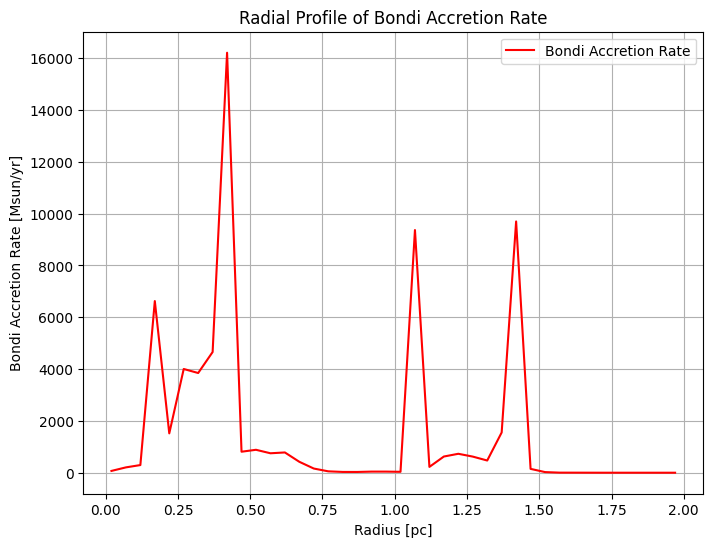

In [14]:

# Gravitational constant in cgs units
G = 6.67e-8*yt.units.cm**3/yt.units.g/yt.units.s**2

# Constants
gamma = 5/3  # Adiabatic index for monoatomic gas
mu = 0.6  # Mean molecular weight for ionized gas (assumed)

def calculate_bondi_rate(ds, center, radius, thickness, M_BH):
    """
    Calculate the Bondi accretion rate through a spherical shell at a given radius.

    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shell (e.g., black hole position).
    radius : float
        The radius of the spherical shell (in pc).
    thickness : float
        The thickness of the shell to approximate the 2D surface (in pc).
    M_BH : yt.Quantity
        The mass of the black hole in solar masses (Msun).

    Returns:
    bondi_rate : yt.Quantity
        The Bondi accretion rate in solar masses per year (Msun/yr).
    """
    
    # Create a spherical shell with a small thickness
    shell = ds.sphere(center, radius + thickness) - ds.sphere(center, radius)

    # Get the gas density and temperature fields
    density = shell[("gas", "density")].in_units("g/cm**3")  # Gas density in g/cm^3
    temperature = shell[("gas", "temperature")].in_units("K")  # Temperature in Kelvin

    # Calculate sound speed: c_s = sqrt(gamma * k_B * T / (mu * m_p))
    sound_speed = shell[("gas", "sound_speed")].in_units("cm/s")  # Sound speed in cm/s
    gas_velocity = shell[("gas", "velocity_magnitude")].in_units("cm/s")  # Gas velocity magnitude in cm/s

    # Bondi rate: 4 * pi * G^2 * M_BH^2 * rho / c_s^3
    bondi_rate_per_cell = 4 * np.pi * G**2 * (M_BH**2) * density / (sound_speed**2 + gas_velocity**2)**(3/2)  # Bondi rate per cell

    # Sum the Bondi rate over all cells in the shell
    total_bondi_rate = np.sum(bondi_rate_per_cell).to("Msun/yr")
    
    return total_bondi_rate

def plot_bondi_rate_profile(ds, center, M_BH, min_radius=0, max_radius=2, step=0.02):
    """
    Plot the radial profile of Bondi accretion rate from 0 to 2 pc in steps of 0.02 pc.

    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shells (e.g., black hole position).
    M_BH : float
        The black hole mass in solar masses (Msun).
    min_radius : float
        The minimum radius to start calculating the Bondi rate (in pc).
    max_radius : float
        The maximum radius to stop calculating the Bondi rate (in pc).
    step : float
        The step size for the radial profile (in pc).
    """
    
    # Initialize arrays for radius and Bondi rates
    radii = np.arange(min_radius, max_radius, step)*yt.units.pc
    bondi_rates = []

    # Get the smallest cell width to use as thickness
    thickness = ds.index.get_smallest_dx().in_units("pc")

    for r in radii:
        bondi_rate = calculate_bondi_rate(ds, center, r, thickness, M_BH)
        bondi_rates.append(bondi_rate)

        # Print out some useful information at each radius
        print(f"Radius = {r:.2f}, Bondi rate = {bondi_rate:.2e}")

    # Plotting the radial profile of Bondi accretion rate
    plt.figure(figsize=(8, 6))
    plt.plot(radii, bondi_rates, label="Bondi Accretion Rate", color='red')
    plt.xlabel("Radius [pc]")
    plt.ylabel("Bondi Accretion Rate [Msun/yr]")
    plt.title("Radial Profile of Bondi Accretion Rate")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352")
center = ss_pos  # Set this to your black hole position or desired center
M_BH =  ss_mass # Example black hole mass of 1 million solar masses

# Plot the radial profile of Bondi accretion rate
plot_bondi_rate_profile(ds, center, M_BH, min_radius=0.02*yt.units.pc, max_radius=2*yt.units.pc, step=0.05*yt.units.pc)


# Specific Energy Density in Feedback Regions

This is to be used as a volume-of-feedback-zone-independent measure of the intensity of the thermal feedback deposited in the simulations. Units are ergs/s/g.

Can we define a threshold below which feedback is ineffective?

## Event 1

yt : [INFO     ] 2024-10-21 09:51:05,681 Parameters: current_time              = 14.213796969306
yt : [INFO     ] 2024-10-21 09:51:05,683 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:51:05,684 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:51:05,686 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:51:05,688 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:51:05,689 Parameters: current_redshift          = 25.946794958957
yt : [INFO     ] 2024-10-21 09:51:05,690 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:51:05,693 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:51:05,695 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:51:05,696 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2565/2565 [00:00<00:00, 14267.34it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0153
r_cells: 5


yt : [INFO     ] 2024-10-21 09:51:35,685 xlim = 0.490380 0.490381
yt : [INFO     ] 2024-10-21 09:51:35,688 ylim = 0.494609 0.494610
yt : [INFO     ] 2024-10-21 09:51:35,694 xlim = 0.490380 0.490381
yt : [INFO     ] 2024-10-21 09:51:35,696 ylim = 0.494609 0.494610
yt : [INFO     ] 2024-10-21 09:51:35,707 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.5095575


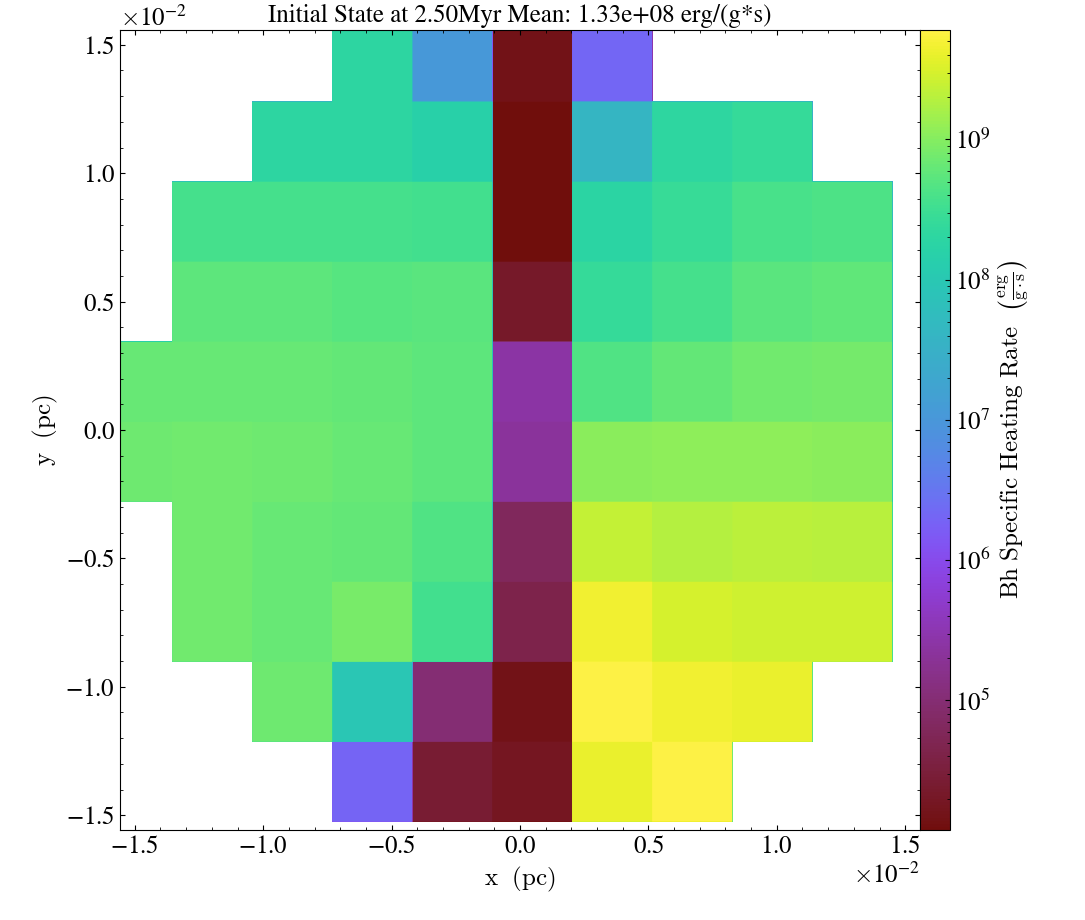

yt : [INFO     ] 2024-10-21 09:51:37,234 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:51:37,236 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:51:37,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:51:37,238 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:51:37,240 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:51:37,242 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:51:37,243 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:51:37,244 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:51:37,246 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:51:37,247 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2794/2794 [00:00<00:00, 19107.08it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0352
r_cells: 5


yt : [INFO     ] 2024-10-21 09:51:41,568 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-21 09:51:41,570 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-21 09:51:41,578 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-21 09:51:41,579 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-21 09:51:41,584 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.5095498


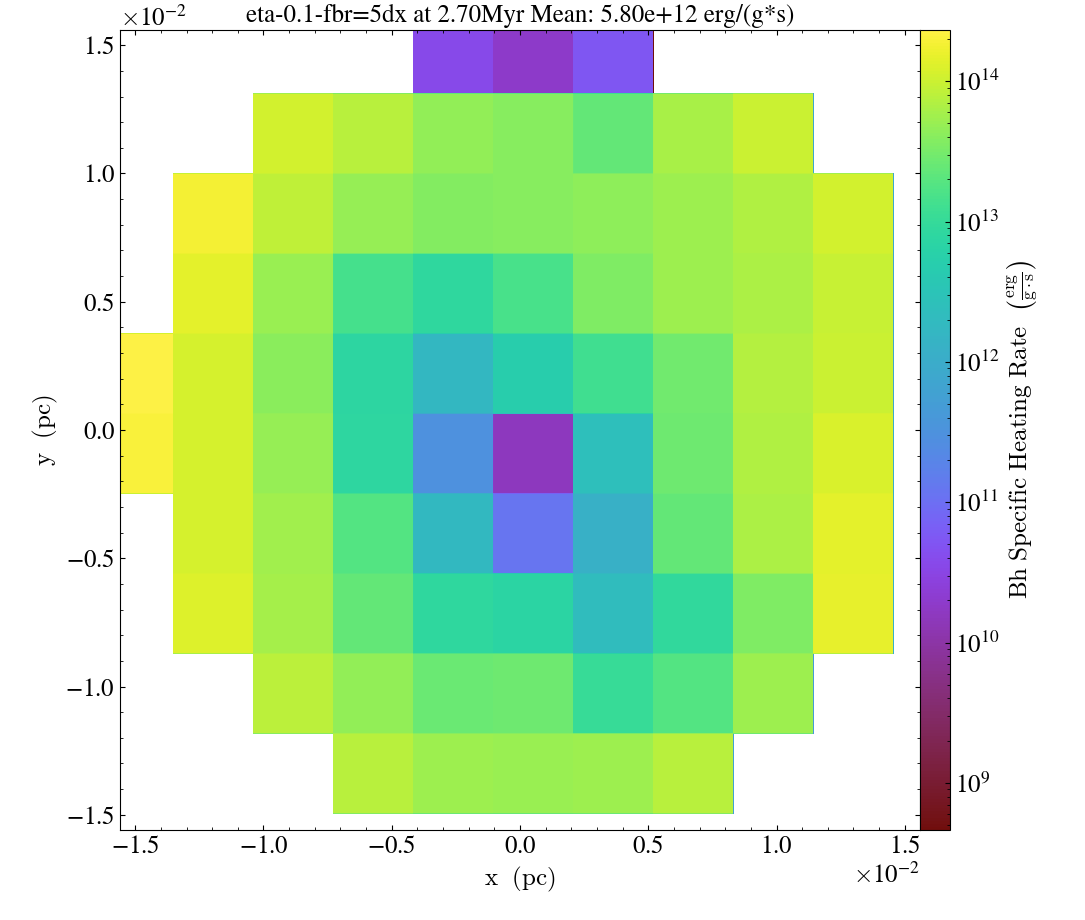

yt : [INFO     ] 2024-10-21 09:51:42,883 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:51:42,885 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:51:42,886 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:51:42,887 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:51:42,888 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:51:42,889 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:51:42,890 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:51:42,891 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:51:42,892 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:51:42,893 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2827/2827 [00:00<00:00, 16826.79it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0352
r_cells: 7


yt : [INFO     ] 2024-10-21 09:52:14,646 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-21 09:52:14,648 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-21 09:52:14,656 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-21 09:52:14,657 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-21 09:52:14,662 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.5095498


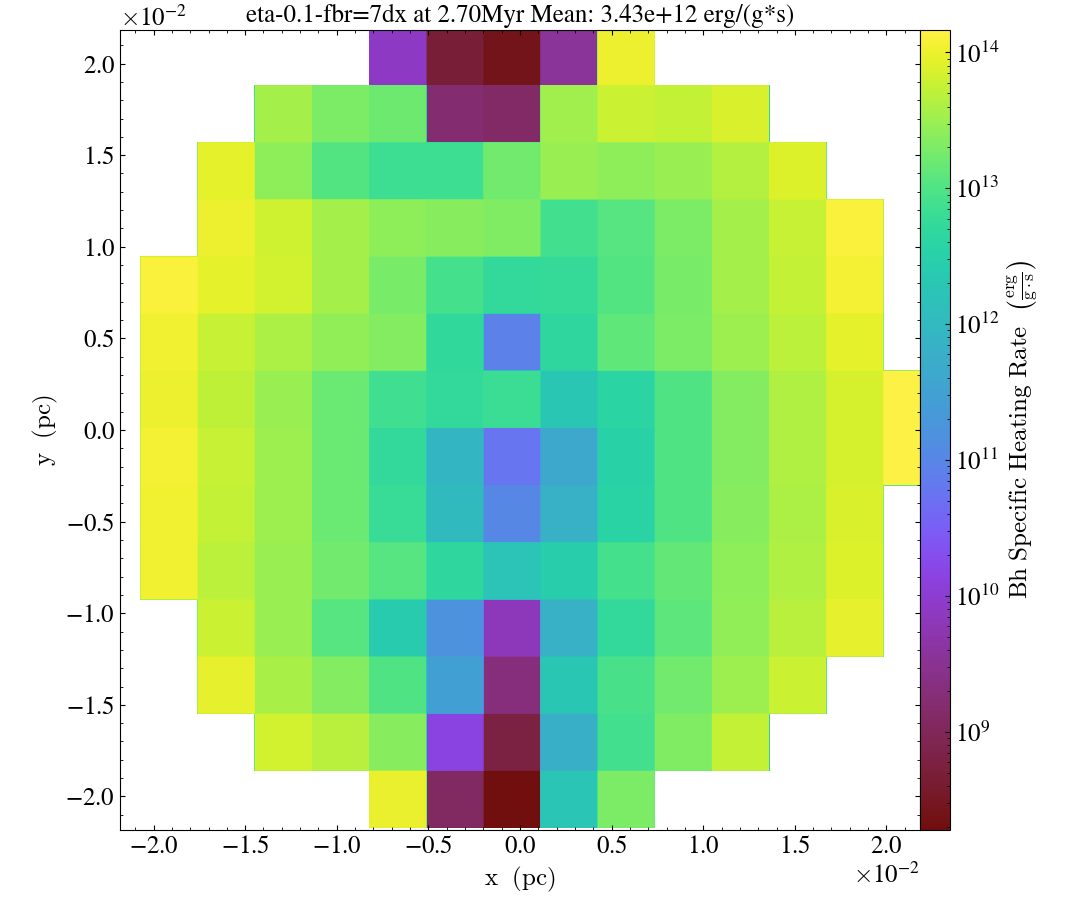

yt : [INFO     ] 2024-10-21 09:52:16,085 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:52:16,086 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:52:16,088 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:52:16,090 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:52:16,091 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:52:16,092 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:52:16,093 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:52:16,093 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:52:16,094 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:52:16,095 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2745/2745 [00:00<00:00, 16971.68it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0352
r_cells: 10


yt : [INFO     ] 2024-10-21 09:52:46,112 xlim = 0.490370 0.490373
yt : [INFO     ] 2024-10-21 09:52:46,113 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-21 09:52:46,122 xlim = 0.490370 0.490373
yt : [INFO     ] 2024-10-21 09:52:46,124 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-21 09:52:46,129 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] cod


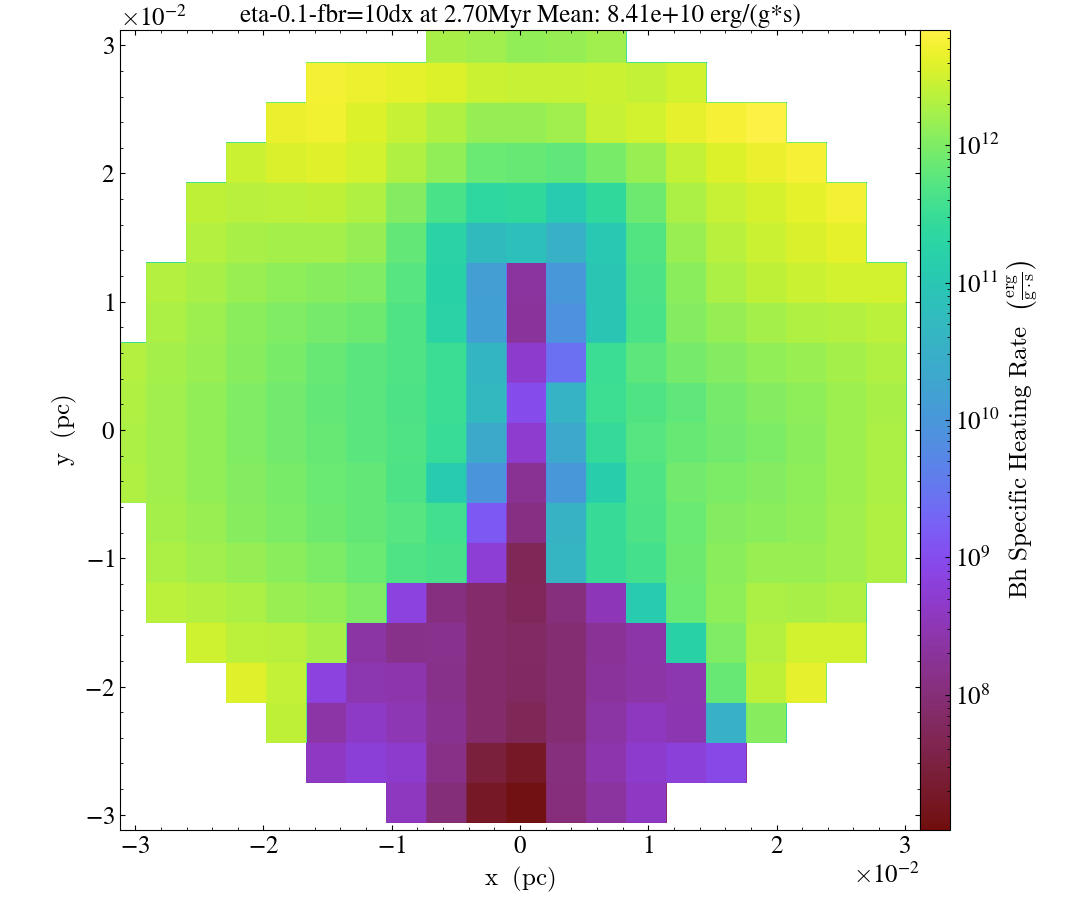

yt : [INFO     ] 2024-10-21 09:52:47,461 Parameters: current_time              = 14.255679763682
yt : [INFO     ] 2024-10-21 09:52:47,463 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:52:47,464 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:52:47,466 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:52:47,467 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:52:47,468 Parameters: current_redshift          = 25.893987347198
yt : [INFO     ] 2024-10-21 09:52:47,469 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:52:47,470 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:52:47,471 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:52:47,472 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3398/3398 [00:00<00:00, 16381.91it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0330
r_cells: 5


yt : [INFO     ] 2024-10-21 09:53:22,987 xlim = 0.490363 0.490365
yt : [INFO     ] 2024-10-21 09:53:22,989 ylim = 0.494599 0.494600
yt : [INFO     ] 2024-10-21 09:53:22,998 xlim = 0.490363 0.490365
yt : [INFO     ] 2024-10-21 09:53:23,000 ylim = 0.494599 0.494600
yt : [INFO     ] 2024-10-21 09:53:23,004 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412


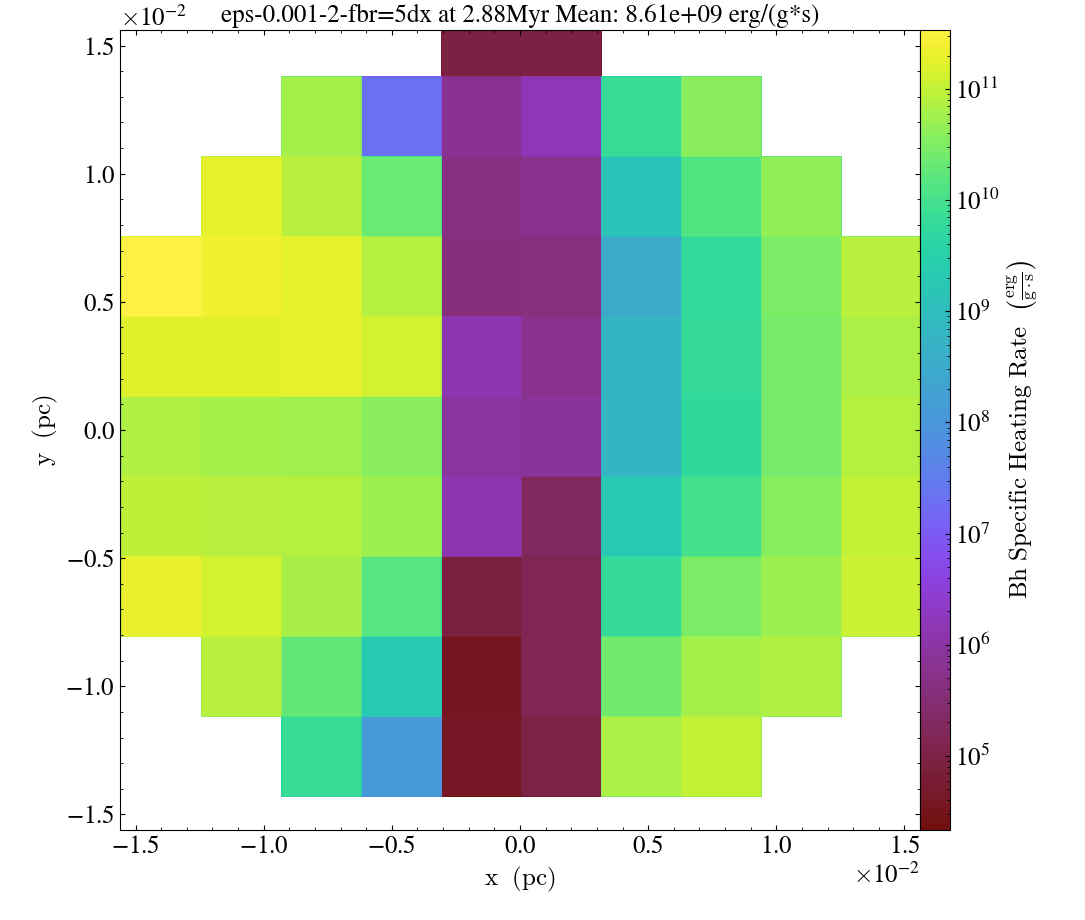

yt : [INFO     ] 2024-10-21 09:53:24,316 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:53:24,318 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:53:24,319 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:53:24,320 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:53:24,321 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:53:24,322 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:53:24,323 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:53:24,324 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:53:24,325 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:53:24,326 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2750/2750 [00:00<00:00, 18828.49it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0352
r_cells: 5


yt : [INFO     ] 2024-10-21 09:53:35,776 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-21 09:53:35,777 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-21 09:53:35,786 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-21 09:53:35,788 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-21 09:53:35,793 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.5095498


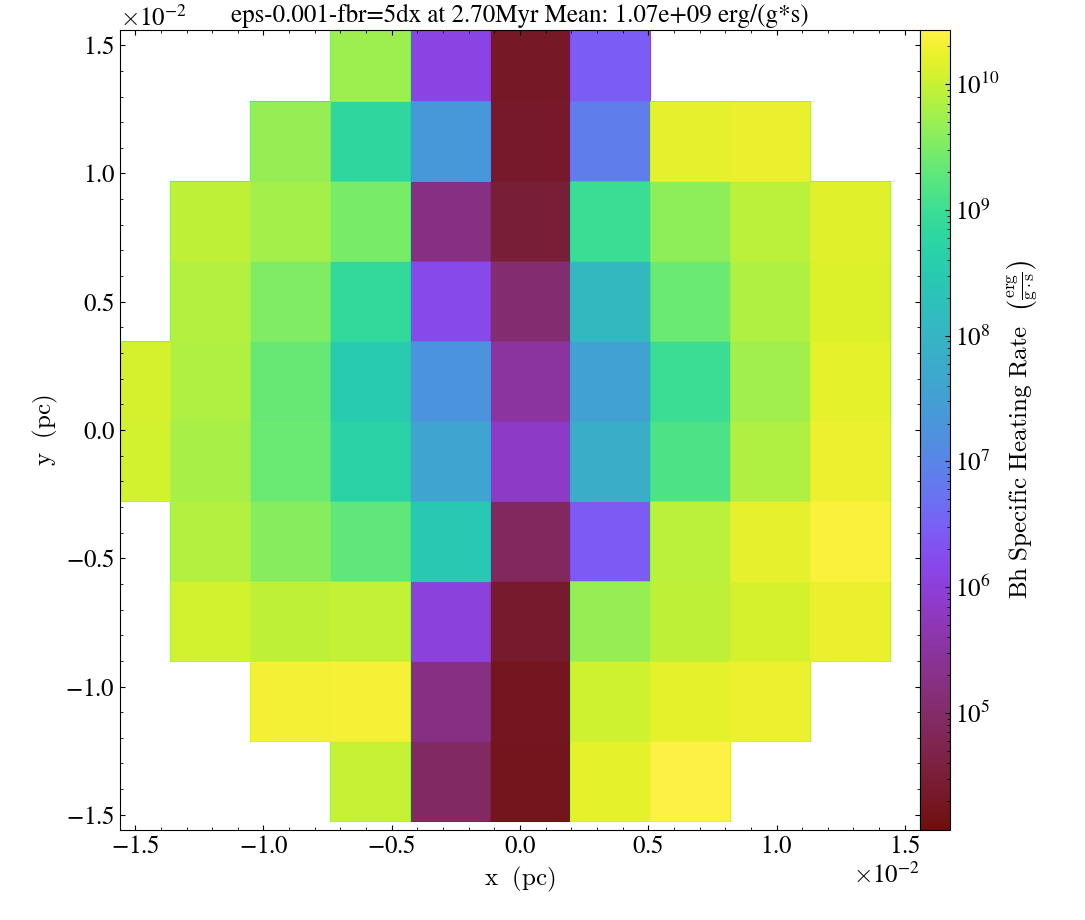

In [15]:
simulations_1 = [
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04/DD0153/DD0153", "name": "Initial State", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/DD0352/DD0352", "name": "eta-0.1-fbr=5dx", "epsilon": 0.005 },
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/fb-r-7dx/DD0352/DD0352", "name": "eta-0.1-fbr=7dx", "epsilon": 0.005},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/fb-r-10dx/DD0352/DD0352", "name": "eta-0.1-fbr=10dx", "epsilon": 0.005},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001-2/DD0330/DD0330", "name": "eps-0.001-2-fbr=5dx", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352", "name": "eps-0.001-fbr=5dx", "epsilon": 1e-5},
]
E1_specific_heating_rate_means = []
for sim in simulations_1:
    ds = yt.load(sim["path"])
    ad = ds.all_data()

    # feedback sphere around black hole
    pos = ad["SmartStar", "particle_position"][0]
    pos, mass, age = ss_properties(ds)
    try:
        r_cells = ds.parameters['SmartStarBHThermalFeedbackRadiusinCells']
    except KeyError:
        r_cells = 5
    print(f"r_cells: {r_cells}")
    dx = ds.find_field_values_at_point([("index", "dx")], pos)[0].to('pc')
    sphere = ds.sphere(pos, dx * r_cells)

    bh_prepare_object(sphere, epsilon=sim["epsilon"])

    ds.add_field(("gas", "BH_specific_heating_rate"), function=_bh_specific_heating_rate, sampling_type="local", units="erg/s/g", force_override=True)
    ds.add_field(("gas", "BH_accretion_cooling_time"), function=_bh_accretion_cooling_time, sampling_type="local", units="s", force_override=True)
    ds.add_field(("gas", "BH_accretion_heating_to_cooling_ratio"), function=_bh_accretion_heating_to_cooling_ratio, sampling_type="local", units="", force_override=True)

    p = yt.SlicePlot(ds, "z", [("gas", "BH_specific_heating_rate")],
                        data_source=sphere, center=sphere.center,
                        width=2*sphere.radius.to('pc'))
    #p.set_unit("BH_accretion_cooling_time", "Myr")
    mean_rate = np.mean(sphere[("gas", "BH_specific_heating_rate")])
    E1_specific_heating_rate_means.append({"name": sim["name"], "mean [erg/(g*s)]": mean_rate.d})
    p.annotate_title(f"{sim['name']} at {age[0]/1e6:.2f}Myr Mean: {mean_rate:.2e}")
    p.show()


In [27]:
df = pd.DataFrame(E1_specific_heating_rate_means, columns=["name", "mean [erg/(g*s)]"])
df_sorted = df.sort_values(by="mean [erg/(g*s)]", ascending=True)
df_sorted["mean [erg/(g*s)]"] = df_sorted["mean [erg/(g*s)]"].apply(lambda x: f'{x:.2e}')
df_sorted

,name,mean [erg/(g*s)]
0,Initial State,1.33e+08
5,eps-0.001-fbr=5dx,1.07e+09
4,eps-0.001-2-fbr=5dx,8.61e+09
3,eta-0.1-fbr=10dx,8.41e+10
2,eta-0.1-fbr=7dx,3.43e+12
1,eta-0.1-fbr=5dx,5.80e+12


## Event 2

yt : [INFO     ] 2024-10-21 09:57:29,555 Parameters: current_time              = 17.475156649306
yt : [INFO     ] 2024-10-21 09:57:29,556 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:57:29,558 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:57:29,559 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:57:29,561 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:57:29,562 Parameters: current_redshift          = 22.479904727113
yt : [INFO     ] 2024-10-21 09:57:29,563 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:57:29,565 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:57:29,566 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:57:29,567 Parameters: hubble_constant           = 0.71
Parsing Hierarchy :   0%|          | 0/4002 [00:00<?, ?it/s]

Parsing Hierarchy : 100%|██████████| 4002/4002 [00:00<00:00, 5681.26it/s] 
yt : [INFO     ] 2024-10-21 09:57:30,403 Gathering a field list (this may take a moment.)


ds =  DD0445
r_cells: 5


yt : [INFO     ] 2024-10-21 09:58:13,273 xlim = 0.488071 0.488075
yt : [INFO     ] 2024-10-21 09:58:13,275 ylim = 0.492886 0.492891
yt : [INFO     ] 2024-10-21 09:58:13,284 xlim = 0.488071 0.488075
yt : [INFO     ] 2024-10-21 09:58:13,286 ylim = 0.492886 0.492891
yt : [INFO     ] 2024-10-21 09:58:13,292 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.48807305 0.49288818 0.50827452]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [3.72546124e-07] code_mass/code_time
bh_pos: [[0.48807305 0.49288818 0.50827452]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [3.72546124e-07] code_mass/code_time
bh_pos: [[0.48807305 0.49288818 0.50827452]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [3.72546124e-07] code_mass/code_time
bh_pos: [[0.48807305 0.49288818 0.50827452]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [3.72546124e-07] code_mass/code_time
bh_pos: [[0.48807305 0.49288818 0.50827452]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [3.72546124e-07] code_mass/code_time
bh_pos: [[0.48807305 0.49288818 0.50827452]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [3.72546124e-07] code_mass/code_time
bh_pos: [[0.48807305 0.49288818 0.50827452]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [3.72546124e-07] code_mass/code_time
bh_pos: [[0.48807305 0.49288818 0.5082745


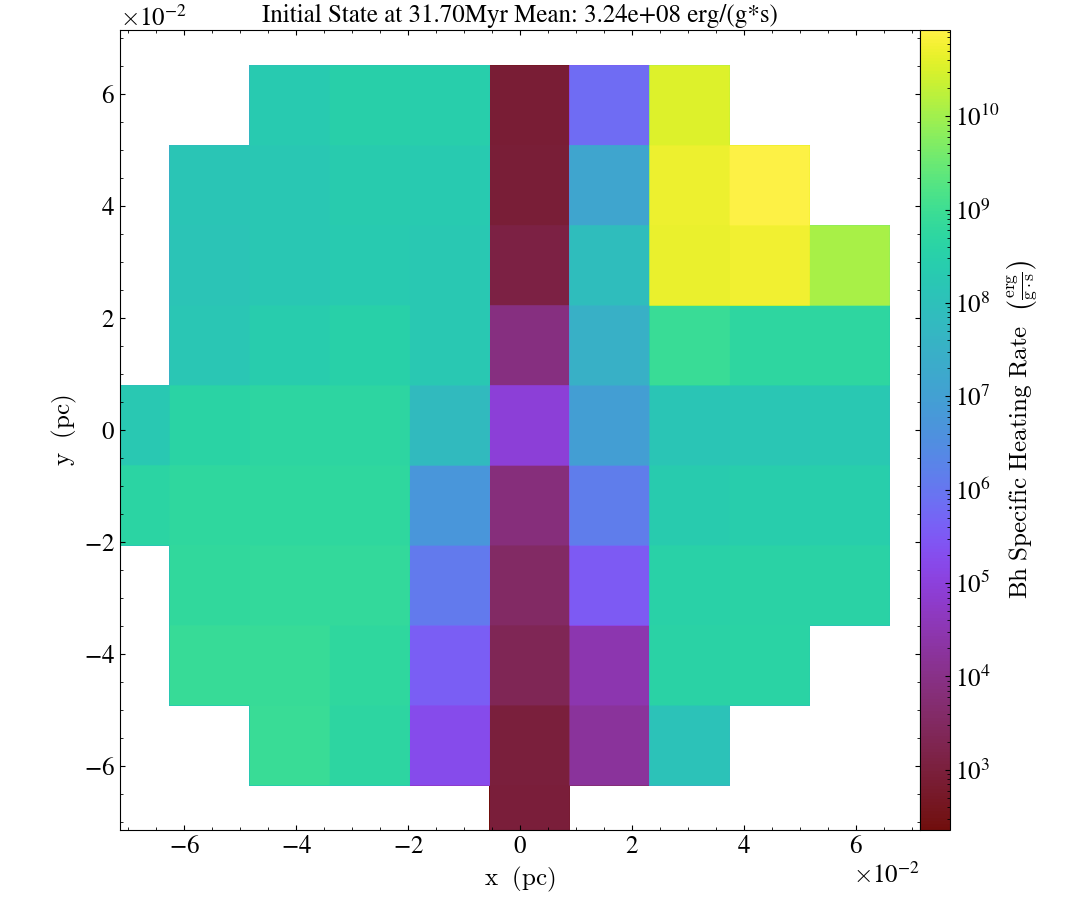

yt : [INFO     ] 2024-10-21 09:58:14,230 Parameters: current_time              = 17.497426609442
yt : [INFO     ] 2024-10-21 09:58:14,231 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:58:14,233 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:58:14,234 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:58:14,236 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:58:14,237 Parameters: current_redshift          = 22.459976303832
yt : [INFO     ] 2024-10-21 09:58:14,238 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:58:14,239 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:58:14,240 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:58:14,241 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 4035/4035 [00:00<00:00, 7096.87it/s]
yt : [INFO     ] 2024-10-21

ds =  DD0702
r_cells: 10


yt : [INFO     ] 2024-10-21 09:58:59,267 xlim = 0.488053 0.488062
yt : [INFO     ] 2024-10-21 09:58:59,269 ylim = 0.492871 0.492880
yt : [INFO     ] 2024-10-21 09:58:59,277 xlim = 0.488053 0.488062
yt : [INFO     ] 2024-10-21 09:58:59,279 ylim = 0.492871 0.492880
yt : [INFO     ] 2024-10-21 09:58:59,284 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.48805739 0.49287566 0.50825836]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [2.06302251e-06] code_mass/code_time
bh_pos: [[0.48805739 0.49287566 0.50825836]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [2.06302251e-06] code_mass/code_time
bh_pos: [[0.48805739 0.49287566 0.50825836]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [2.06302251e-06] code_mass/code_time
bh_pos: [[0.48805739 0.49287566 0.50825836]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [2.06302251e-06] code_mass/code_time
bh_pos: [[0.48805739 0.49287566 0.50825836]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [2.06302251e-06] code_mass/code_time
bh_pos: [[0.48805739 0.49287566 0.50825836]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [2.06302251e-06] code_mass/code_time
bh_pos: [[0.48805739 0.49287566 0.50825836]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [2.06302251e-06] code_mass/code_time
bh_pos: [[0.48805739 0.49287566 0.5082583


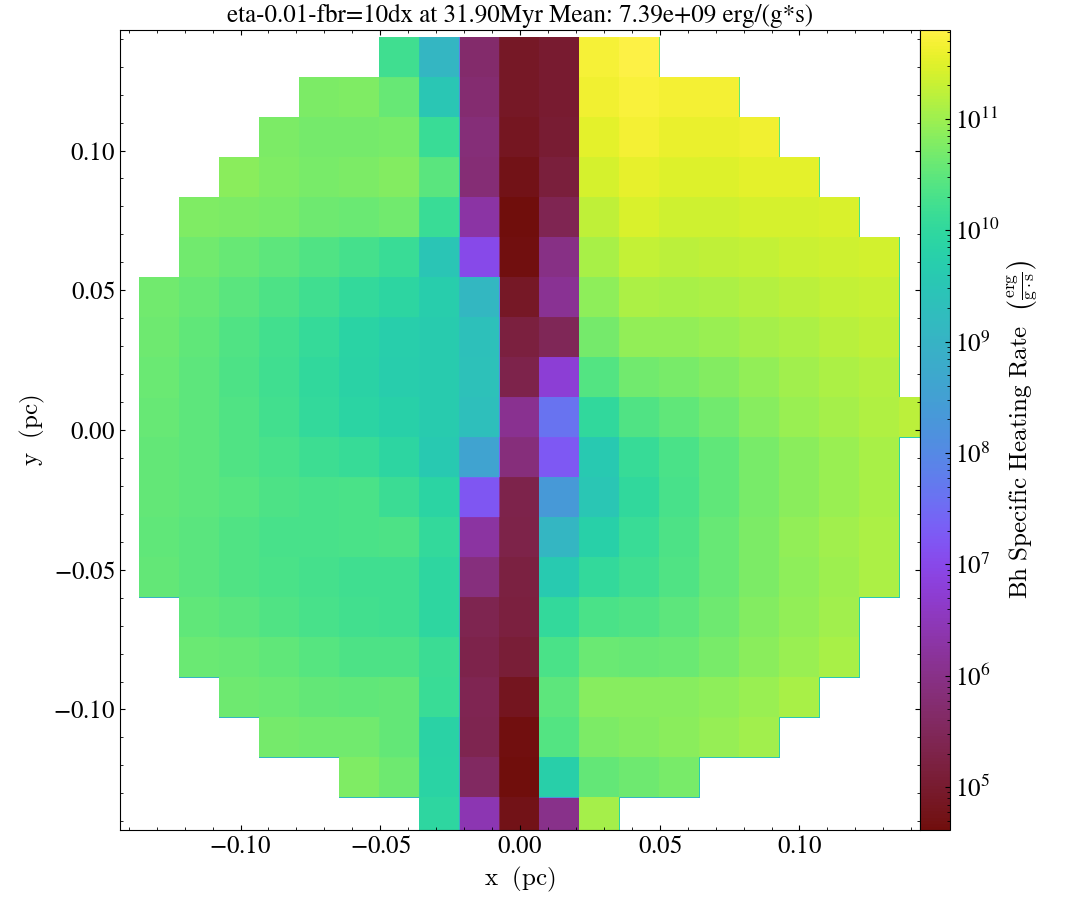

yt : [INFO     ] 2024-10-21 09:59:00,286 Parameters: current_time              = 17.497426609442
yt : [INFO     ] 2024-10-21 09:59:00,287 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:59:00,289 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:59:00,290 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:59:00,292 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:59:00,293 Parameters: current_redshift          = 22.459976303832
yt : [INFO     ] 2024-10-21 09:59:00,294 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:59:00,295 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:59:00,296 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:59:00,297 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3941/3941 [00:00<00:00, 6351.20it/s]
yt : [INFO     ] 2024-10-21

ds =  DD0702
r_cells: 7


yt : [INFO     ] 2024-10-21 09:59:43,813 xlim = 0.488055 0.488062
yt : [INFO     ] 2024-10-21 09:59:43,815 ylim = 0.492872 0.492879
yt : [INFO     ] 2024-10-21 09:59:43,823 xlim = 0.488055 0.488062
yt : [INFO     ] 2024-10-21 09:59:43,825 ylim = 0.492872 0.492879
yt : [INFO     ] 2024-10-21 09:59:43,830 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.48805864 0.49287565 0.50825824]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805864 0.49287565 0.50825824]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805864 0.49287565 0.50825824]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805864 0.49287565 0.50825824]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805864 0.49287565 0.50825824]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805864 0.49287565 0.50825824]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805864 0.49287565 0.50825824]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805864 0.49287565 0.5082582


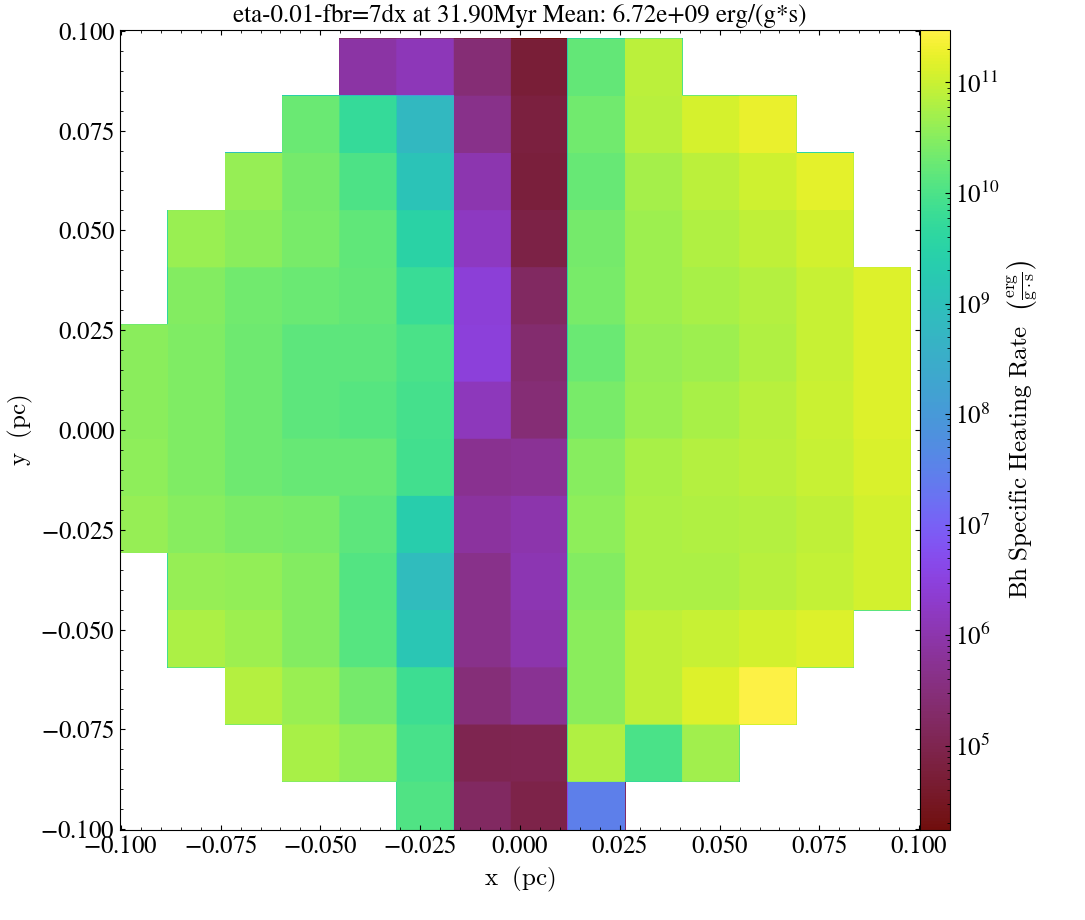

yt : [INFO     ] 2024-10-21 09:59:45,321 Parameters: current_time              = 17.497046862082
yt : [INFO     ] 2024-10-21 09:59:45,323 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:59:45,325 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:59:45,327 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:59:45,329 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:59:45,330 Parameters: current_redshift          = 22.460315768987
yt : [INFO     ] 2024-10-21 09:59:45,331 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:59:45,333 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:59:45,334 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:59:45,335 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 4531/4531 [00:00<00:00, 17887.87it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0641
r_cells: 5


yt : [INFO     ] 2024-10-21 10:00:30,880 xlim = 0.488055 0.488060
yt : [INFO     ] 2024-10-21 10:00:30,883 ylim = 0.492873 0.492878
yt : [INFO     ] 2024-10-21 10:00:30,890 xlim = 0.488055 0.488060
yt : [INFO     ] 2024-10-21 10:00:30,892 ylim = 0.492873 0.492878
yt : [INFO     ] 2024-10-21 10:00:30,897 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.48805775 0.49287561 0.50825789]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [7.01372506e-09] code_mass/code_time
bh_pos: [[0.48805775 0.49287561 0.50825789]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [7.01372506e-09] code_mass/code_time
bh_pos: [[0.48805775 0.49287561 0.50825789]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [7.01372506e-09] code_mass/code_time
bh_pos: [[0.48805775 0.49287561 0.50825789]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [7.01372506e-09] code_mass/code_time
bh_pos: [[0.48805775 0.49287561 0.50825789]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [7.01372506e-09] code_mass/code_time
bh_pos: [[0.48805775 0.49287561 0.50825789]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [7.01372506e-09] code_mass/code_time
bh_pos: [[0.48805775 0.49287561 0.50825789]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [7.01372506e-09] code_mass/code_time
bh_pos: [[0.48805775 0.49287561 0.5082578


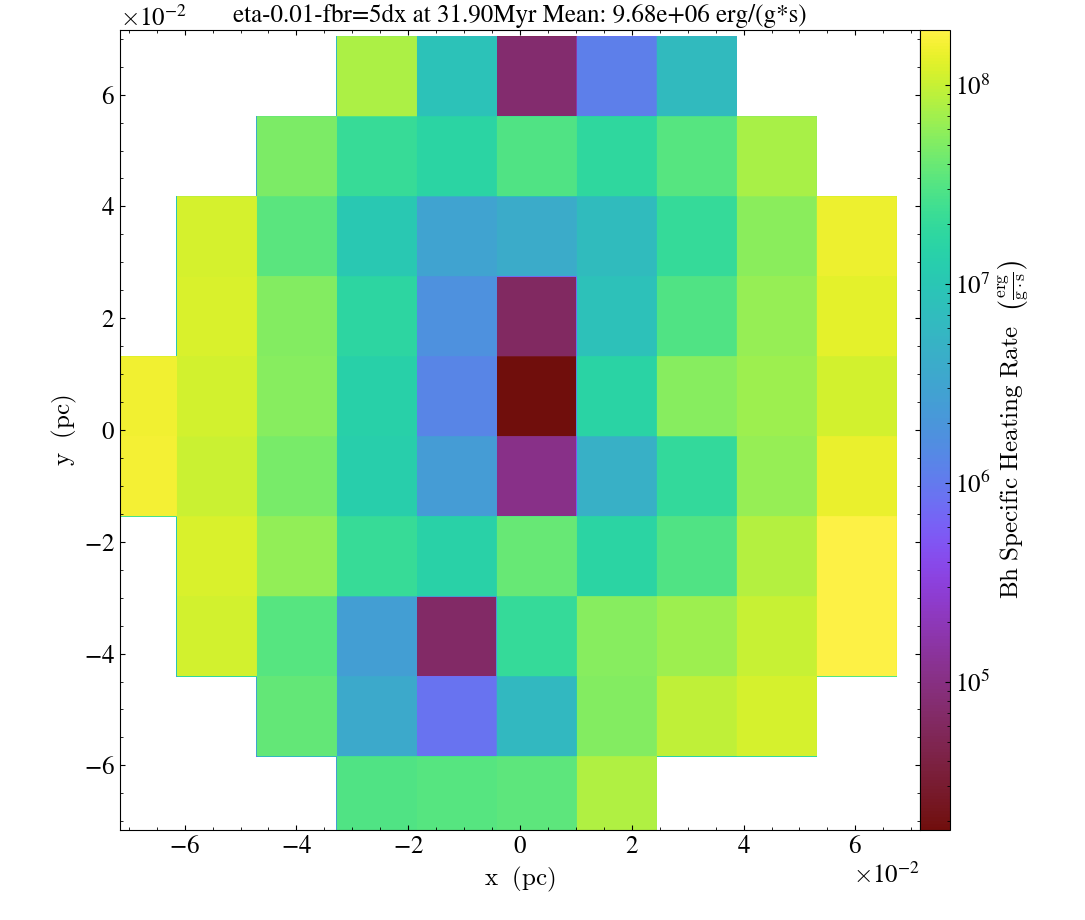

In [28]:
simulations_2 = [
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eps-0.001/DD0445/DD0445", "name": "Initial State", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.01/fb-radius=10dx/DD0702/DD0702", "name": "eta-0.01-fbr=10dx", "epsilon": 5e-4},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.01/fb-radius=7dx/DD0702/DD0702", "name": "eta-0.01-fbr=7dx", "epsilon": 5e-4},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.01/DD0641/DD0641", "name": "eta-0.01-fbr=5dx", "epsilon": 5e-4},
]

E2_specific_heating_rate_means = []
for sim in simulations_2:
    ds = yt.load(sim["path"])
    ad = ds.all_data()

    # feedback sphere around black hole
    pos = ad["SmartStar", "particle_position"][0]
    pos, mass, age = ss_properties(ds)
    try:
        r_cells = ds.parameters['SmartStarBHThermalFeedbackRadiusinCells']
    except KeyError:
        r_cells = 5
    print(f"r_cells: {r_cells}")
    dx = ds.find_field_values_at_point([("index", "dx")], pos)[0].to('pc')
    sphere = ds.sphere(pos, dx * r_cells)

    bh_prepare_object(sphere, epsilon=sim["epsilon"])

    ds.add_field(("gas", "BH_specific_heating_rate"), function=_bh_specific_heating_rate, sampling_type="local", units="erg/s/g", force_override=True)
    ds.add_field(("gas", "BH_accretion_cooling_time"), function=_bh_accretion_cooling_time, sampling_type="local", units="s", force_override=True)
    ds.add_field(("gas", "BH_accretion_heating_to_cooling_ratio"), function=_bh_accretion_heating_to_cooling_ratio, sampling_type="local", units="", force_override=True)

    p = yt.SlicePlot(ds, "z", [("gas", "BH_specific_heating_rate")],
                        data_source=sphere, center=sphere.center,
                        width=2*sphere.radius.to('pc'))
    #p.set_unit("BH_accretion_cooling_time", "Myr")
    mean_rate = np.mean(sphere[("gas", "BH_specific_heating_rate")])
    E2_specific_heating_rate_means.append({"name": sim["name"], "mean [erg/(g*s)]": mean_rate.d})
    p.annotate_title(f"{sim['name']} at {age[0]/1e6:.2f}Myr Mean: {mean_rate:.2e}")
    p.show()

In [29]:
df = pd.DataFrame(E2_specific_heating_rate_means, columns=["name", "mean [erg/(g*s)]"])
df_sorted = df.sort_values(by="mean [erg/(g*s)]", ascending=True)
df_sorted["mean [erg/(g*s)]"] = df_sorted["mean [erg/(g*s)]"].apply(lambda x: f'{x:.2e}')
df_sorted

,name,mean [erg/(g*s)]
3,eta-0.01-fbr=5dx,9.68e+06
0,Initial State,3.24e+08
2,eta-0.01-fbr=7dx,6.72e+09
1,eta-0.01-fbr=10dx,7.39e+09


## Event 3

yt : [INFO     ] 2024-10-21 10:01:13,239 Parameters: current_time              = 22.571567263226
yt : [INFO     ] 2024-10-21 10:01:13,241 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 10:01:13,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 10:01:13,244 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 10:01:13,247 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 10:01:13,248 Parameters: current_redshift          = 18.79683233109
yt : [INFO     ] 2024-10-21 10:01:13,249 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 10:01:13,251 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 10:01:13,252 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 10:01:13,254 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 4167/4167 [00:00<00:00, 12863.50it/s]
yt : [INFO     ] 2024-10-21

ds =  DD0263
r_cells: 5


yt : [INFO     ] 2024-10-21 10:02:23,809 xlim = 0.499222 0.499224
yt : [INFO     ] 2024-10-21 10:02:23,812 ylim = 0.496339 0.496341
yt : [INFO     ] 2024-10-21 10:02:23,820 xlim = 0.499222 0.499224
yt : [INFO     ] 2024-10-21 10:02:23,822 ylim = 0.496339 0.496341
yt : [INFO     ] 2024-10-21 10:02:23,827 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] cod


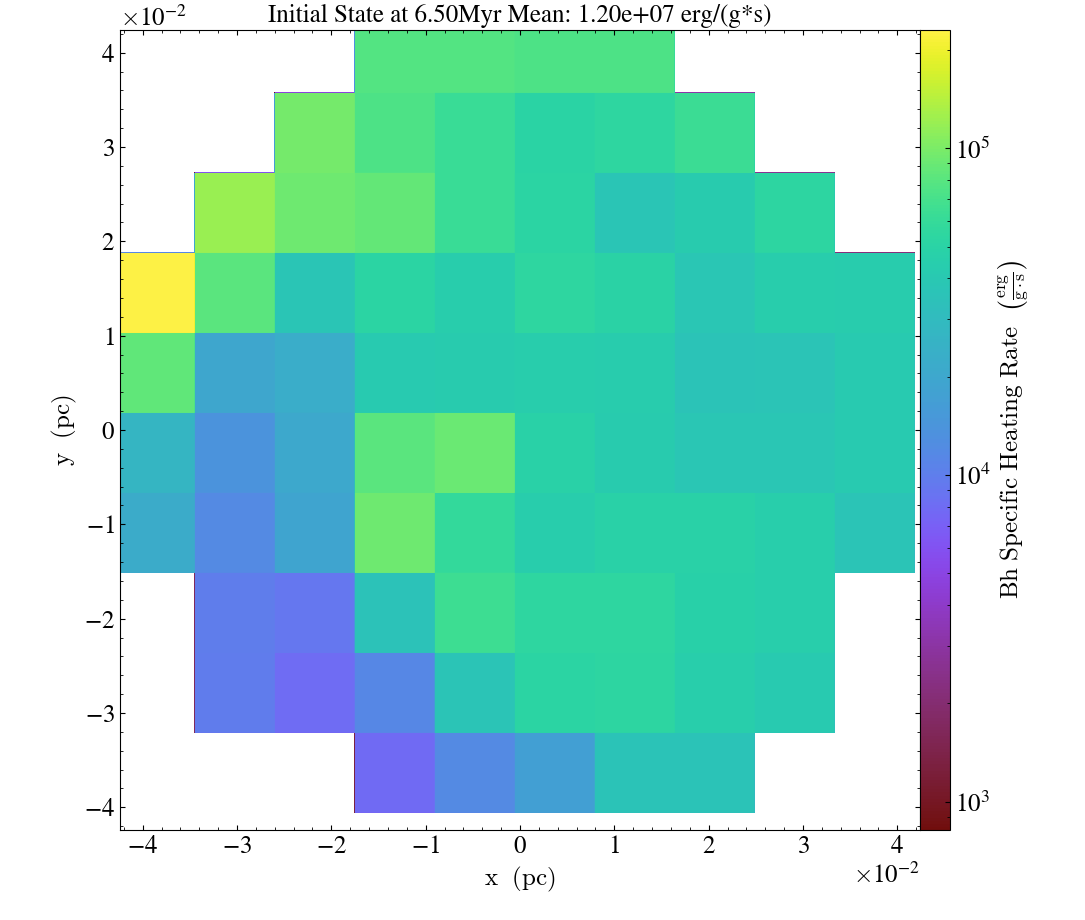

yt : [INFO     ] 2024-10-21 10:02:24,819 Parameters: current_time              = 22.594038266082
yt : [INFO     ] 2024-10-21 10:02:24,821 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 10:02:24,822 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 10:02:24,823 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 10:02:24,824 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 10:02:24,825 Parameters: current_redshift          = 18.783702555462
yt : [INFO     ] 2024-10-21 10:02:24,826 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 10:02:24,827 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 10:02:24,828 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 10:02:24,829 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3226/3226 [00:00<00:00, 14401.68it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0511
r_cells: 5


yt : [INFO     ] 2024-10-21 10:03:06,897 xlim = 0.499229 0.499230
yt : [INFO     ] 2024-10-21 10:03:06,899 ylim = 0.496345 0.496346
yt : [INFO     ] 2024-10-21 10:03:06,907 xlim = 0.499229 0.499230
yt : [INFO     ] 2024-10-21 10:03:06,909 ylim = 0.496345 0.496346
yt : [INFO     ] 2024-10-21 10:03:06,915 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.4992292  0.49634547 0.49132734]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.4992292  0.49634547 0.49132734]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.4992292  0.49634547 0.49132734]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.4992292  0.49634547 0.49132734]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.4992292  0.49634547 0.49132734]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.4992292  0.49634547 0.49132734]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.4992292  0.49634547 0.49132734]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.4992292  0.49634547 0.4913273


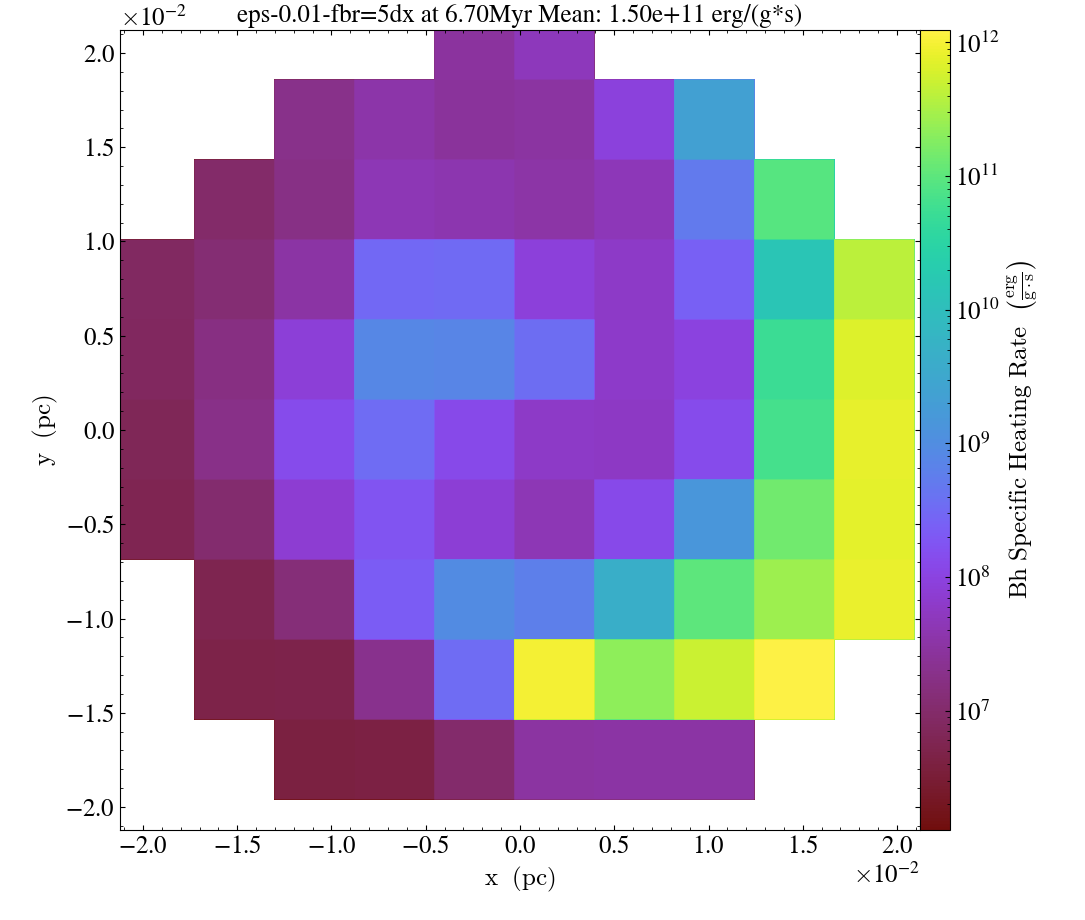

yt : [INFO     ] 2024-10-21 10:03:07,971 Parameters: current_time              = 22.593859561442
yt : [INFO     ] 2024-10-21 10:03:07,973 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 10:03:07,975 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 10:03:07,977 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 10:03:07,978 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 10:03:07,980 Parameters: current_redshift          = 18.783806886472
yt : [INFO     ] 2024-10-21 10:03:07,981 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 10:03:07,982 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 10:03:07,985 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 10:03:07,986 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3312/3312 [00:00<00:00, 3912.42it/s]
yt : [INFO     ] 2024-10-21

ds =  DD0900
r_cells: 5


yt : [INFO     ] 2024-10-21 10:03:50,432 xlim = 0.499228 0.499230
yt : [INFO     ] 2024-10-21 10:03:50,434 ylim = 0.496345 0.496346
yt : [INFO     ] 2024-10-21 10:03:50,442 xlim = 0.499228 0.499230
yt : [INFO     ] 2024-10-21 10:03:50,443 ylim = 0.496345 0.496346
yt : [INFO     ] 2024-10-21 10:03:50,448 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49922893 0.4963457  0.49132681]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922893 0.4963457  0.49132681]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922893 0.4963457  0.49132681]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922893 0.4963457  0.49132681]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922893 0.4963457  0.49132681]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922893 0.4963457  0.49132681]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922893 0.4963457  0.49132681]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922893 0.4963457  0.4913268


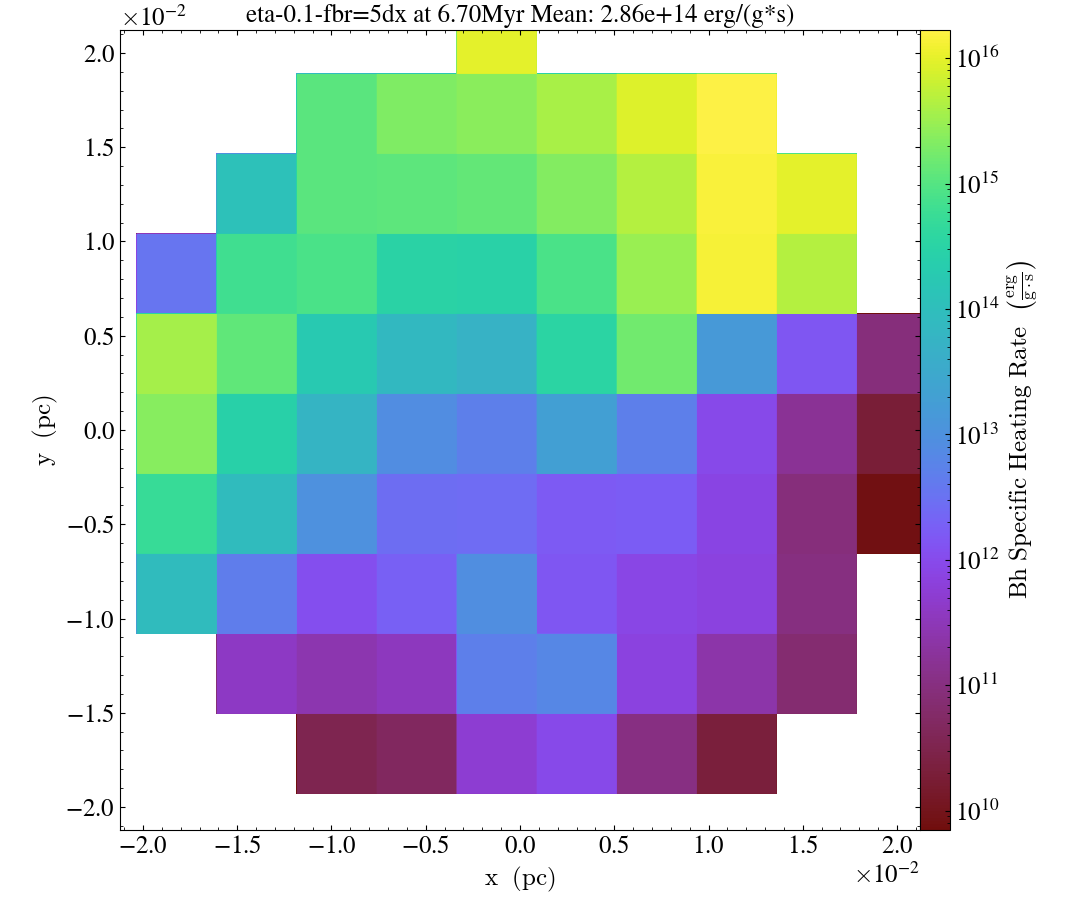

yt : [INFO     ] 2024-10-21 10:03:51,513 Parameters: current_time              = 22.593725532962
yt : [INFO     ] 2024-10-21 10:03:51,515 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 10:03:51,517 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 10:03:51,519 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 10:03:51,520 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 10:03:51,522 Parameters: current_redshift          = 18.783885135632
yt : [INFO     ] 2024-10-21 10:03:51,524 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 10:03:51,525 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 10:03:51,526 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 10:03:51,528 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3377/3377 [00:00<00:00, 4048.99it/s] 
yt : [INFO     ] 2024-10-2

ds =  DD0600
r_cells: 5


yt : [INFO     ] 2024-10-21 10:04:34,097 xlim = 0.499228 0.499230
yt : [INFO     ] 2024-10-21 10:04:34,099 ylim = 0.496346 0.496347
yt : [INFO     ] 2024-10-21 10:04:34,106 xlim = 0.499228 0.499230
yt : [INFO     ] 2024-10-21 10:04:34,109 ylim = 0.496346 0.496347
yt : [INFO     ] 2024-10-21 10:04:34,114 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49922898 0.49634612 0.49132706]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922898 0.49634612 0.49132706]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922898 0.49634612 0.49132706]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922898 0.49634612 0.49132706]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922898 0.49634612 0.49132706]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922898 0.49634612 0.49132706]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922898 0.49634612 0.49132706]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922898 0.49634612 0.4913270


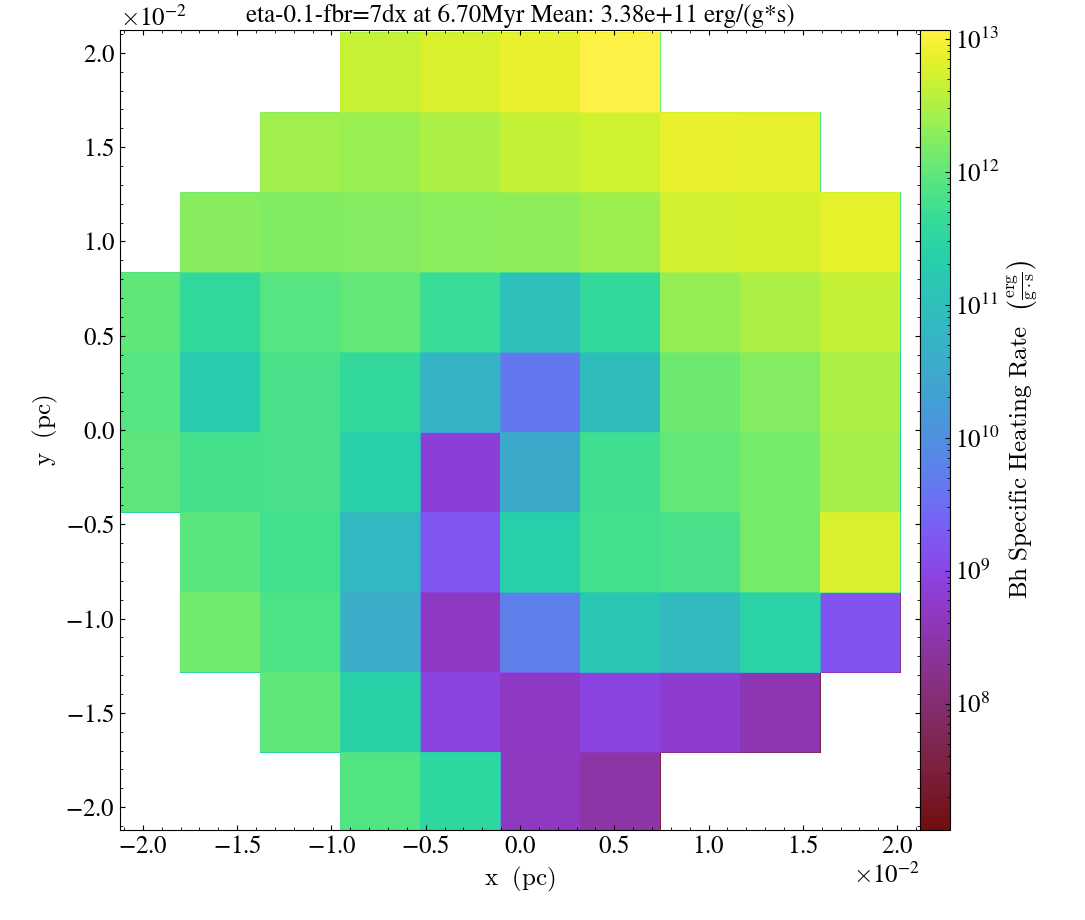

In [31]:
simulations_3 = [
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.001/DD0263/DD0263", "name": "Initial State", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.01/DD0511/DD0511", "name": "eps-0.01-fbr=5dx", "epsilon": 5e-4},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01/DD0900/DD0900", "name": "eta-0.1-fbr=5dx", "epsilon": 0.005},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01/2B.resim.th.b01-fb-r-7dx/DD0600/DD0600", "name": "eta-0.1-fbr=7dx", "epsilon": 0.005},
]
E3_specific_heating_rate_means = []
for sim in simulations_3:
    ds = yt.load(sim["path"])
    ad = ds.all_data()

    # feedback sphere around black hole
    pos = ad["SmartStar", "particle_position"][0]
    pos, mass, age = ss_properties(ds)
    try:
        r_cells = ds.parameters['SmartStarBHThermalFeedbackRadiusinCells']
    except KeyError:
        r_cells = 5
    print(f"r_cells: {r_cells}")
    dx = ds.find_field_values_at_point([("index", "dx")], pos)[0].to('pc')
    sphere = ds.sphere(pos, dx * r_cells)

    bh_prepare_object(sphere, epsilon=sim["epsilon"])

    ds.add_field(("gas", "BH_specific_heating_rate"), function=_bh_specific_heating_rate, sampling_type="local", units="erg/s/g", force_override=True)
    ds.add_field(("gas", "BH_accretion_cooling_time"), function=_bh_accretion_cooling_time, sampling_type="local", units="s", force_override=True)
    ds.add_field(("gas", "BH_accretion_heating_to_cooling_ratio"), function=_bh_accretion_heating_to_cooling_ratio, sampling_type="local", units="", force_override=True)

    p = yt.SlicePlot(ds, "z", [("gas", "BH_specific_heating_rate")],
                        data_source=sphere, center=sphere.center,
                        width=2*sphere.radius.to('pc'))
    #p.set_unit("BH_accretion_cooling_time", "Myr")
    mean_rate = np.mean(sphere[("gas", "BH_specific_heating_rate")])
    E3_specific_heating_rate_means.append({"name": sim["name"], "mean [erg/(g*s)]": mean_rate.d})
    p.annotate_title(f"{sim['name']} at {age[0]/1e6:.2f}Myr Mean: {mean_rate:.2e}")
    p.show()

In [32]:
df = pd.DataFrame(E3_specific_heating_rate_means, columns=["name", "mean [erg/(g*s)]"])
df_sorted = df.sort_values(by="mean [erg/(g*s)]", ascending=True)
df_sorted["mean [erg/(g*s)]"] = df_sorted["mean [erg/(g*s)]"].apply(lambda x: f'{x:.2e}')
df_sorted

,name,mean [erg/(g*s)]
0,Initial State,1.20e+07
1,eps-0.01-fbr=5dx,1.50e+11
3,eta-0.1-fbr=7dx,3.38e+11
2,eta-0.1-fbr=5dx,2.86e+14


## All

In [35]:
# join the dataframes
df_all = pd.concat([pd.DataFrame(E1_specific_heating_rate_means), pd.DataFrame(E2_specific_heating_rate_means), pd.DataFrame(E3_specific_heating_rate_means)], ignore_index=True)
df_sorted_all = df_all.sort_values(by="mean [erg/(g*s)]", ascending=True)
df_sorted_all["mean [erg/(g*s)]"] = df_sorted_all["mean [erg/(g*s)]"].apply(lambda x: f'{x:.2e}')
df_sorted_all

,name,mean [erg/(g*s)]
9,eta-0.01-fbr=5dx,9.68e+06
10,Initial State,1.20e+07
0,Initial State,1.33e+08
6,Initial State,3.24e+08
5,eps-0.001-fbr=5dx,1.07e+09
8,eta-0.01-fbr=7dx,6.72e+09
7,eta-0.01-fbr=10dx,7.39e+09
4,eps-0.001-2-fbr=5dx,8.61e+09
3,eta-0.1-fbr=10dx,8.41e+10
11,eps-0.01-fbr=5dx,1.50e+11


/tmp/ipykernel_200843/2314111077.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, len(df_all["name"]))


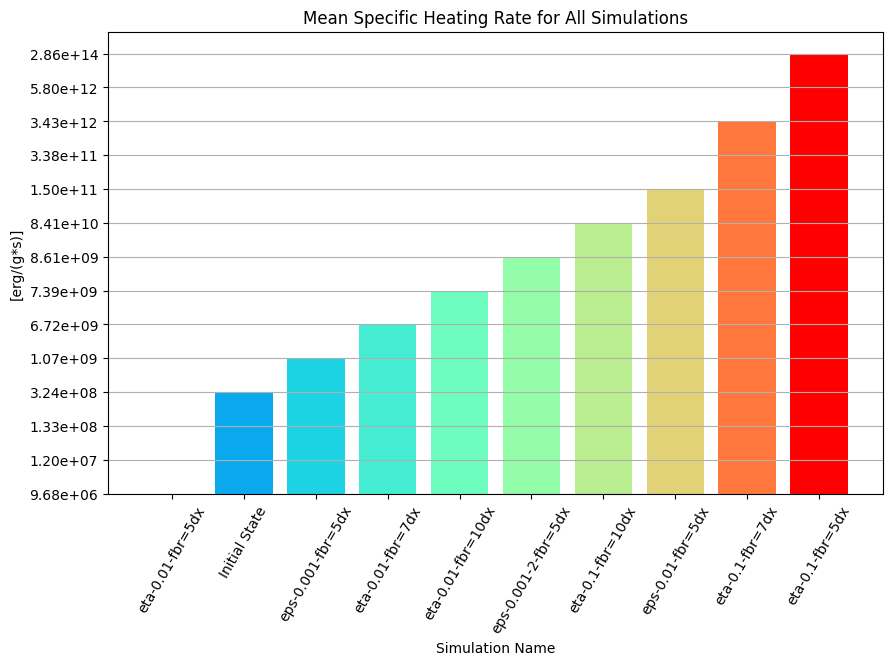

In [83]:
# Plot the mean specific heating rate for all simulations
import matplotlib.cm as cm  # Import colormap module
plt.figure(figsize=(10, 6))
# Access a colormap from yt (for example, 'viridis' is also available in yt)
cmap = "rainbow"
cmap = cm.get_cmap(cmap, len(df_sorted_all["name"]))
colors = [cmap(i) for i in range(len(df_sorted_all["name"]) +10)]

plt.bar(df_sorted_all["name"], df_sorted_all["mean [erg/(g*s)]"], color=colors)
plt.xlabel("Simulation Name")
plt.ylabel("[erg/(g*s)]")
#plt.yscale("log")
plt.title("Mean Specific Heating Rate for All Simulations")
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.show()

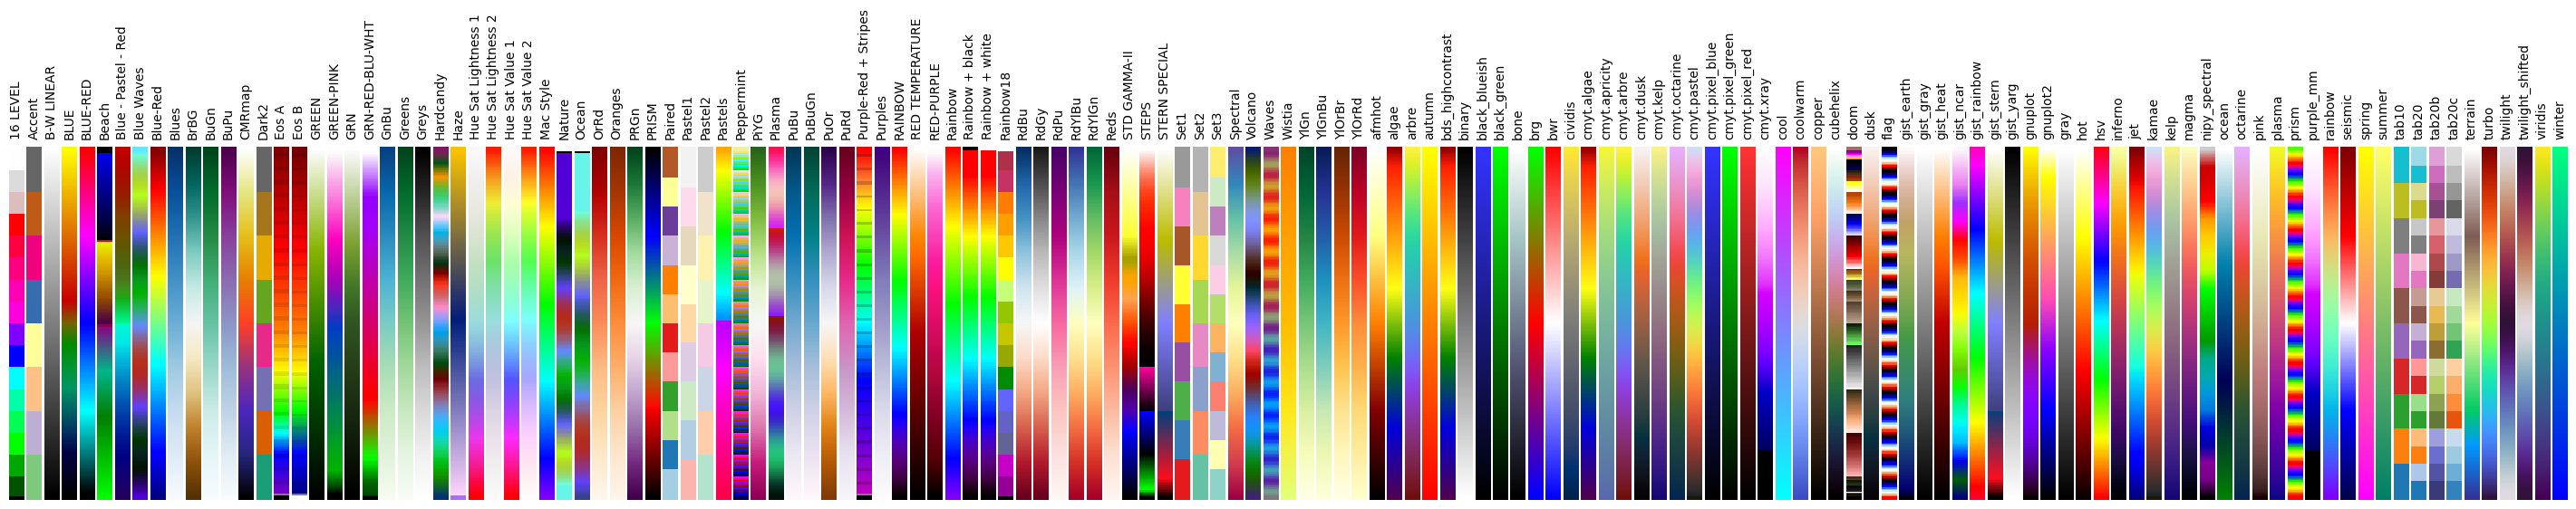

In [58]:
yt.show_colormaps()

# Misc

In [187]:
data = sphere
cell_pos = data.ds.arr([data["index", ax] for ax in "xyz"]).T
bh_pos = data.get_field_parameter("bh_centers")
bh_r = data.get_field_parameter("bh_feedback_radii")
mdot = data.get_field_parameter("accretion_rate")
print(f"bh_pos: {bh_pos}, bh_r: {bh_r.to('pc')}, mdot: {mdot.to('Msun/yr')}") # sensible values

bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [0.01559326] pc, mdot: [0.00114115] Msun/yr


In [213]:
epsilon = 0.001 * 0.01
field_data = data.ds.arr(np.zeros(data["gas", "density"].shape), "erg/s/g")
# loop over each bh and add heating where d < r
for i in range(bh_r.size):
    my_pos = bh_pos[i]
    my_r2 = bh_r[i]**2
    d2 = ((cell_pos - my_pos)**2).sum(axis=1)
    my_mdot = mdot[i]
    my_filter = d2 <= my_r2
    field_data[my_filter] = epsilon * c**2 * my_mdot / data["gas", "cell_mass"] / my_filter.sum()

In [177]:
d2 = ((cell_pos - my_pos)**2).sum(axis=1)
my_filter.sum()

529